# Inerpretation-Net

## Specification of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'function_family': {
        'maximum_depth': 3,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,    
        'dt_type': 'SDT', #'SDT', 'vanilla'
    },
    'data': {
        'number_of_variables': 23, 
        'num_classes': 2,
        'categorical_indices': [],
        
        'use_distribution_list': True,
        'random_parameters_distribution': True, 
        'max_distributions_per_class': 1, # None; 0; int >= 1  
        'exclude_linearly_seperable': True,
        'data_generation_filtering': False,
        'fixed_class_probability': False,
        'balanced_data': True,
        'weighted_data_generation': False,
        'shift_distrib': False,
        
        'dt_type_train': 'vanilla', # (None, 'vanilla', 'SDT')
        'maximum_depth_train': 3, #None or int
        'decision_sparsity_train': 1, #None or int
        
        'function_generation_type': 'distribution',
        'distrib_by_feature': True,
        'distribution_list': ['uniform', 'normal', 'gamma', 'beta', 'poisson'], 
        'distribution_list_eval': ['uniform', 'normal', 'gamma', 'beta', 'poisson'],
        
        'objective': 'classification', 
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', 
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', 
        
        'data_noise': 0, #None or float
        
        'distrib_param_max': 5,
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-3,
        'restore_best_weights': True,
        'patience_lambda': 50,
        
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'use_batchnorm_lambda': False,
        
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy',
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    
    'i_net': {
        'dense_layers': [4096, 2048],
        
        'dropout': [0, 0.5],

        'hidden_activation': 'swish',

        'optimizer': 'adam', 
        
        'learning_rate': 0.001, 
        
        'separate_weight_bias': False,
        
        'convolution_layers': None,
        'lstm_layers': None,        
        'additional_hidden': False,
        
        'loss': 'binary_crossentropy', 
        'metrics': ['binary_accuracy'],
        
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,

        'interpretation_dataset_size': 10000,
                
        'test_size': 5, #Float for fraction, Int for number 0
        'evaluate_distribution': True,
        'force_evaluate_real_world': False,
        
        'function_representation_type': 3, 
        'normalize_lambda_nets': False,

        'optimize_decision_function': True, 
        'function_value_loss': True, 
                      
        'data_reshape_version': None,
        
        'resampling_strategy': None,
        'resampling_threshold': 0.25,
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', 
        'nas_trials': 60,
        'nas_optimizer': 'greedy' 
    },    
    
    'evaluation': {           
        'number_of_random_evaluations_per_distribution': 10,
        'random_evaluation_dataset_size_per_distribution': 10_000, 
        'optimize_sampling': True,
            
        'random_evaluation_dataset_size': 500, 
        'random_evaluation_dataset_distribution': 'uniform', 
        
        'per_network_optimization_dataset_size': 5000,

        #'sklearn_dt_benchmark': False,
        #'sdt_benchmark': False,
        
        'different_eval_data': False,
        
        'eval_data_description': {
            ######### data #########
            'eval_data_function_generation_type': 'make_classification',
            'eval_data_lambda_dataset_size': 5000, #number of samples per function
            'eval_data_noise_injected_level': 0, 
            'eval_data_noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'     
            ######### lambda_net #########
            'eval_data_number_of_trained_lambda_nets': 100,
            ######### i_net #########
            'eval_data_interpretation_dataset_size': 100,
        }
        
    },    
    
    'computation':{
        'load_model': False,
        'n_jobs': 15,
        'use_gpu': False,
        'gpu_numbers': '2',
        'RANDOM_SEED': 42,   
        'verbosity': 0
    }
}


### Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

from itertools import product       
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import shutil

from copy import deepcopy
import math
import random 


import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output

from prettytable import PrettyTable

from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import xgboost as xgb



In [4]:
tf.__version__

'2.8.0'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
config['function_family']['decision_sparsity'] = config['function_family']['decision_sparsity'] if config['function_family']['decision_sparsity'] != -1 else config['data']['number_of_variables'] 

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)
np.set_printoptions(suppress=True)



In [6]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(config)
config['function_family']['basic_function_representation_length'] = get_number_of_function_parameters(dt_type, maximum_depth, number_of_variables, num_classes)
config['function_family']['function_representation_length'] = ( 
       #((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
       (2 ** maximum_depth - 1) * (number_of_variables + 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth)  if function_representation_type >= 3 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes if function_representation_type >= 3 and dt_type == 'SDT'
  else None
                                                            )


if distrib_by_feature:
    config['evaluation']['random_evaluation_dataset_distribution'] = config['data']['distribution_list_eval']
    config['data']['distribution_list'] = [config['data']['distribution_list']]
    config['data']['distribution_list_eval'] = [config['data']['distribution_list_eval']]
  
    

#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))

create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)  

In [8]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize5000_numLNets10000_var23_class2_distribution_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_randClassProb_exLinSepun-no-ga-be-po_depth3_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.001_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense4096-2048_drop0-0.5e500b256_adam_funcRep3_reshapeNone
lNetSize5000_numLNets10000_var23_class2_distribution_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_randClassProb_exLinSepun-no-ga-be-po_depth3_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.001_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
#%load_ext autoreload
#%autoreload 2

In [11]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    #if psutil.virtual_memory().percent > 80:
        #raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['data']['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    
    
    #path_X_data = directory + 'X_test_lambda.txt'
    #path_y_data = directory + 'y_test_lambda.txt'
    
    if True:
        path_X_data = './data/saved_function_lists/X_data_' + path_dict['path_identifier_function_data'] + '.pkl'
        with open(path_X_data, 'rb') as f:
            X_data_list = pickle.load(f)

        path_y_data = './data/saved_function_lists/y_data_' + path_dict['path_identifier_function_data'] + '.pkl'
        with open(path_y_data, 'rb') as f:
            y_data_list = pickle.load(f)        
            
    path_distribution_parameters = directory + '/' + 'distribution_parameters' + '.txt'
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    
    try:
        distribution_parameters = pd.read_csv(path_distribution_parameters, sep=",", header=None)
        distribution_parameters = distribution_parameters.sort_values(by=0)
    except:
        distribution_parameters = pd.DataFrame([None] * network_parameters.shape[0])
    
    #if no_noise == False:
    #    network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    #    distribution_parameters = distribution_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              distribution_parameters_row,
                                              #X_test_lambda_row, 
                                              #y_test_lambda_row, 
                                              X_test_network[1].values,
                                              y_test_network[1].values,
                                              config) for X_test_network, y_test_network, network_parameters_row, distribution_parameters_row in zip(X_data_list[:config['i_net']['interpretation_dataset_size']], 
                                                                                                                                                     y_data_list[:config['i_net']['interpretation_dataset_size']], 
                                                                                                                                                     network_parameters.values[:config['i_net']['interpretation_dataset_size']], 
                                                                                                                                                     distribution_parameters.values[:config['i_net']['interpretation_dataset_size']]))        
    del parallel
    
    base_model = generate_base_model(config)  
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [12]:
#LOAD DATA
if different_eval_data:
    config_train = deepcopy(config)
    config_eval = deepcopy(config)
    
    config_eval['data']['function_generation_type'] = config['evaluation']['eval_data_description']['eval_data_function_generation_type']
    config_eval['data']['lambda_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_lambda_dataset_size']
    config_eval['data']['noise_injected_level'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_level']
    config_eval['data']['noise_injected_type'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_type'] 
    config_eval['lambda_net']['number_of_trained_lambda_nets'] = config['evaluation']['eval_data_description']['eval_data_number_of_trained_lambda_nets']   
    config_eval['i_net']['interpretation_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_interpretation_dataset_size']   
    

    lambda_net_dataset_train = load_lambda_nets(config_train, n_jobs=n_jobs)
    lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

    if test_size > 0 and not evaluate_distribution:
        lambda_net_dataset_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)   
    else:
        lambda_net_dataset_test = None
        lambda_net_dataset_valid = lambda_net_dataset_eval
        
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    if test_size > 0 and not evaluate_distribution:
        lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)    
    else:
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)    
        lambda_net_dataset_test = None

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:   25.3s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:   26.2s
[Parallel(n_jobs=15)]: Done 657 tasks      | elapsed:   28.9s
[Parallel(n_jobs=15)]: Done 1553 tasks      | elapsed:   32.7s
[Parallel(n_jobs=15)]: Done 2705 tasks      | elapsed:   37.6s
[Parallel(n_jobs=15)]: Done 4113 tasks      | elapsed:   43.1s
[Parallel(n_jobs=15)]: Done 5777 tasks      | elapsed:   50.2s
[Parallel(n_jobs=15)]: Done 7697 tasks      | elapsed:   59.0s
[Parallel(n_jobs=15)]: Done 9873 tasks      | elapsed:  1.1min
[Parallel(n_jobs=15)]: Done 10000 out of 10000 | elapsed:  1.1min finished


### Data Inspection

In [13]:
print(lambda_net_dataset_train.shape)
print(lambda_net_dataset_valid.shape)
if test_size > 0 and not evaluate_distribution:
    print(lambda_net_dataset_test.shape)

(9000, 3387)
(1000, 3387)


In [14]:
lambda_net_dataset_valid.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f0v10,f0v11,f0v12,f0v13,f0v14,f0v15,f0v16,f0v17,f0v18,f0v19,f0v20,f0v21,f0v22,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f1v10,f1v11,f1v12,f1v13,f1v14,f1v15,f1v16,f1v17,f1v18,f1v19,f1v20,f1v21,f1v22,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f2v9,f2v10,f2v11,f2v12,f2v13,f2v14,f2v15,f2v16,f2v17,f2v18,f2v19,f2v20,f2v21,f2v22,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f3v9,f3v10,f3v11,f3v12,f3v13,f3v14,f3v15,f3v16,f3v17,f3v18,f3v19,f3v20,f3v21,f3v22,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,...,wb_3101,wb_3102,wb_3103,wb_3104,wb_3105,wb_3106,wb_3107,wb_3108,wb_3109,wb_3110,wb_3111,wb_3112,wb_3113,wb_3114,wb_3115,wb_3116,wb_3117,wb_3118,wb_3119,wb_3120,wb_3121,wb_3122,wb_3123,wb_3124,wb_3125,wb_3126,wb_3127,wb_3128,wb_3129,wb_3130,wb_3131,wb_3132,wb_3133,wb_3134,wb_3135,wb_3136,wb_3137,wb_3138,wb_3139,wb_3140,wb_3141,wb_3142,wb_3143,wb_3144,wb_3145,wb_3146,wb_3147,wb_3148,wb_3149,wb_3150,wb_3151,wb_3152,wb_3153,wb_3154,wb_3155,wb_3156,wb_3157,wb_3158,wb_3159,wb_3160,wb_3161,wb_3162,wb_3163,wb_3164,wb_3165,wb_3166,wb_3167,wb_3168,wb_3169,wb_3170,wb_3171,wb_3172,wb_3173,wb_3174,wb_3175,wb_3176,wb_3177,wb_3178,wb_3179,wb_3180,wb_3181,wb_3182,wb_3183,wb_3184,wb_3185,wb_3186,wb_3187,wb_3188,wb_3189,wb_3190,wb_3191,wb_3192,wb_3193,wb_3194,wb_3195,wb_3196,wb_3197,wb_3198,wb_3199,wb_3200
6252,6252.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.133,-1.646,-0.318,-0.361,0.193,0.060,-0.188,-0.056,0.263,-0.297,0.214,-0.161,-0.714,-0.485,0.101,0.350,-0.147,-0.241,0.271,-1.060,-0.249,0.311,0.422,2.748,-0.265,-0.057,0.074,-0.085,-0.198,-0.302,-0.334,0.116,-1.245,-0.275,-0.394,-0.297,0.144,0.010,-0.361,0.234,0.241,-0.322,-0.148,-0.267,0.315,-0.514,0.264,-0.292,-0.450,-1.275,-0.274,-0.211,-1.395,0.207,0.340,0.164,-0.560,0.271,-0.242,0.141,-0.243,0.323,-0.038,-0.357,0.096,0.160,-0.145,-0.409,0.159,0.009,1.837,-0.120,0.299,-1.073,-1.285,0.067,0.214,0.252,-0.328,-0.210,-0.361,-0.346,0.364,-0.410,-0.268,-0.366,-0.381,-0.265,-0.352,-0.493,0.276,-0.128,-0.146,-0.284,0.262,0.248,-0.319,0.264,0.128,-0.058
4684,4684.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.138,-0.343,-0.118,-0.193,0.157,0.060,-0.095,-0.664,1.316,-0.729,0.123,-0.175,-0.176,-0.287,0.293,0.304,-0.149,-0.163,0.145,-0.054,-0.009,0.265,0.194,-0.005,-0.054,-0.173,2.690,-0.188,-1.095,-0.225,-0.113,0.119,-0.322,0.075,-1.464,-0.096,0.144,0.247,-0.110,0.122,1.310,-0.207,-0.181,-0.198,0.036,-0.156,0.204,-1.760,-0.197,-1.214,-0.235,-0.556,-0.294,0.199,0.216,0.234,-2.076,0.119,-0.693,0.325,-0.236,0.241,-0.831,-0.185,-0.014,1.306,-0.630,-0.286,0.159,0.062,0.028,-0.599,0.217,-1.116,-1.549,0.163,0.259,0.161,-0.356,-0.210,-0.663,-0.215,0.235,-1.210,-0.007,-0.175,-0.213,-0.118,-0.182,-0.192,0.195,-0.258,-2.001,-1.755,0.117,0.134,-0.046,-0.036,0.427,0.094
1731,1731.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,

In [15]:
lambda_net_dataset_train.samples_class_0_list_array[1]

In [16]:
lambda_net_dataset_train.distribution_dict_row_array[1]

In [17]:
lambda_net_dataset_train.distribution_dict_list_list[1]

# Interpretation Network Training

In [18]:
#%load_ext autoreload
#%autoreload 2

In [19]:
((X_valid, y_valid), 
 (X_test, y_test),
 
 history,
 loss_function,
 metrics,
 
 model,
 encoder_model) = interpretation_net_training(
                                      lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      #callback_names=plot_losses
                                     )



----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
network_parameters_structure [(23, 128), (128,), (128, 1), (1,)]
Epoch 1/500
36/36 - 11s - loss: 0.6991 - binary_accuracy_inet_decision_function_fv_metric: 0.5013 - val_loss: 0.6937 - val_binary_accuracy_inet_decision_function_fv_metric: 0.5030 - lr: 0.0010 - 11s/epoch - 313ms/step
Epoch 3/500
36/36 - 10s - loss: 0.6952 - binary_accuracy_inet_decision_function_fv_metric: 0.5033 - val_loss: 0.6945 - val_binary_accuracy_inet_decision_function_fv_metric: 0.4957 - lr: 0.0010 - 10s/epoch - 273ms/step
Epoch 4/500
36/36 - 9s - loss: 0.6952 - binary_accuracy_inet_decision_function_fv_metric: 0.5044 - val_loss: 0.6913 - val_binary_accuracy_inet_decision_function_fv_metric: 0.5222 - lr: 0.0010 - 9s/epoch - 240ms/step
Epoch 5/500
36/36 - 8s - loss: 0.6944 - binary_accuracy_inet_decision_function_fv_metric: 0.5087 - val_loss: 0.6903 - val_binary_accuracy_inet_decision_functio

<Figure size 432x288 with 0 Axes>

## Evaluate I-Net Training Process

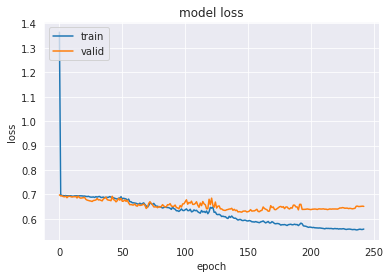

In [20]:
if nas:
    for trial in history: 
        print(trial.summary())
        
    writepath_nas = './results_nas.csv'

    if different_eval_data:
        flat_config = flatten_dict(config_train)
    else:
        flat_config = flatten_dict(config)    

    if not os.path.exists(writepath_nas):
        with open(writepath_nas, 'w+') as text_file:       
            for key in flat_config.keys():
                text_file.write(key)
                text_file.write(';')         

            for hp in history[0].hyperparameters.values.keys():
                text_file.write(hp + ';')    
               
            text_file.write('score')
            
            text_file.write('\n')

    with open(writepath_nas, 'a+') as text_file:  
        for value in flat_config.values():
            text_file.write(str(value))
            text_file.write(';')

        for hp, value in history[0].hyperparameters.values.items():
            text_file.write(str(value) + ';')        

        
        text_file.write(str(history[0].score))
            
        text_file.write('\n')            

        text_file.close()      
        
else:
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')    

In [21]:
if False:
    index = 0
    lambda_net = lambda_net_dataset_train.lambda_net_list[index]
    
    lambda_net_model = network_parameters_to_network(lambda_net.network_parameters, config)
    lambda_net_model_preds = lambda_net_model.predict(lambda_net.X_train_lambda)
    dt_train_data = DecisionTreeClassifier(max_depth=3)
    dt_train_data.fit(lambda_net.X_train_lambda, np.round(lambda_net_model_preds))
    
    random_data = np.random.uniform(0, 1, lambda_net.X_train_lambda.shape)
    lambda_net_model_preds_random = lambda_net_model.predict(random_data)
    dt_random_data = DecisionTreeClassifier(max_depth=3)
    dt_random_data.fit(random_data, np.round(lambda_net_model_preds_random))
    
    plot_decision_area_evaluation(lambda_net.X_train_lambda, 
                                lambda_net.y_train_lambda.flatten(), 
                                lambda_net.X_test_lambda, 
                                lambda_net.y_test_lambda.flatten(),
                                random_data,
                                lambda_net_model_preds_random.flatten(),                                   
                                lambda_net_model,
                                dt_train_data,
                                dt_random_data,
                                dt_random_data,
                                dt_random_data,
                                model.predict(np.array([lambda_net.network_parameters]))[0],
                                np.array([str(i) for i in range(lambda_net.X_train_lambda.shape[1])]),
                                config
                               )

    index = 0
    lambda_net = lambda_net_dataset_valid.lambda_net_list[index]
    
    lambda_net_model = network_parameters_to_network(lambda_net.network_parameters, config)
    lambda_net_model_preds = lambda_net_model.predict(lambda_net.X_train_lambda)
    dt_train_data = DecisionTreeClassifier(max_depth=3)
    dt_train_data.fit(lambda_net.X_train_lambda, np.round(lambda_net_model_preds))
    
    random_data = np.random.uniform(0, 1, lambda_net.X_train_lambda.shape)
    lambda_net_model_preds_random = lambda_net_model.predict(random_data)
    dt_random_data = DecisionTreeClassifier(max_depth=3)
    dt_random_data.fit(random_data, np.round(lambda_net_model_preds_random))
    
    plot_decision_area_evaluation(lambda_net.X_train_lambda, 
                                lambda_net.y_train_lambda.flatten(), 
                                lambda_net.X_test_lambda, 
                                lambda_net.y_test_lambda.flatten(),
                                random_data,
                                lambda_net_model_preds_random.flatten(), 
                                lambda_net_model,
                                dt_train_data,
                                dt_random_data,
                                dt_random_data,
                                dt_random_data,
                                model.predict(np.array([lambda_net.network_parameters]))[0],
                                np.array([str(i) for i in range(lambda_net.X_train_lambda.shape[1])]),
                                config
                               )    

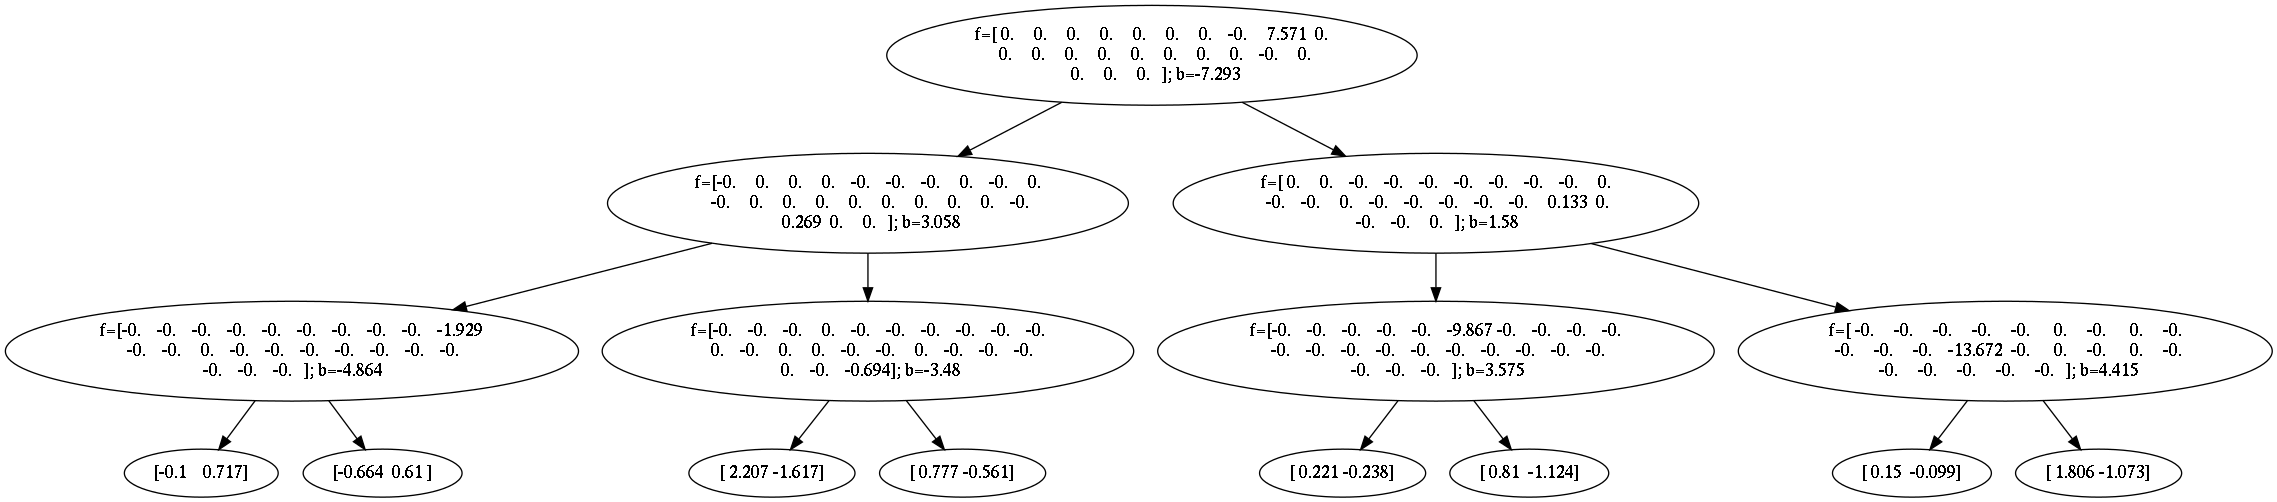

In [22]:
index = 0
if test_size > 0 and not evaluate_distribution:
    network_parameters = np.array([lambda_net_dataset_test.network_parameters_array[index]])
else:
    network_parameters = np.array([lambda_net_dataset_valid.network_parameters_array[index]])
    
if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
elif config['i_net']['data_reshape_version'] == 3: #autoencoder
    encoder_model = load_encoder_model(config)
    network_parameters, network_parameters_flat, _ = autoencode_data(network_parameters, config, encoder_model)    
dt_parameters = model.predict(network_parameters)[0]

if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
image

In [23]:
image = None
if not function_value_loss:
    if test_size > 0 and not evaluate_distribution:
        dt_parameters = y_test[index][:-2 ** config['function_family']['maximum_depth'] ]
    else:
        dt_parameters = y_valid[index][:-2 ** config['function_family']['maximum_depth'] ]

    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
image

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 3201)]       0           []                               
                                                                                                  
 hidden1_4096 (Dense)           (None, 4096)         13115392    ['input[0][0]']                  
                                                                                                  
 activation1_swish (Activation)  (None, 4096)        0           ['hidden1_4096[0][0]']           
                                                                                                  
 hidden2_2048 (Dense)           (None, 2048)         8390656     ['activation1_swish[0][0]']      
                                                                                              

    Normal: This is useful for looking at means and other linear combinations (e.g. regression coefficients) because of the CLT. Related to that is if something is known to arise due to additive effects of many different small causes then the normal may be a reasonable distribution: for example, many biological measures are the result of multiple genes and multiple environmental factors and therefor are often approximately normal.

    Gamma: Right skewed and useful for things with a natural minimum at 0. Commonly used for elapsed times and some financial variables.

    Exponential: special case of the Gamma. It is memoryless and scales easily.

    Chi-squared (𝜒2): special case of the Gamma. Arises as sum of squared normal variables (so used for variances).

    Beta: Defined between 0 and 1 (but could be transformed to be between other values), useful for proportions or other quantities that must be between 0 and 1.

    Binomial: How many "successes" out of a given number of independent trials with same probability of "success".

    Poisson: Common for counts. Nice properties that if the number of events in a period of time or area follows a Poisson, then the number in twice the time or area still follows the Poisson (with twice the mean): this works for adding Poissons or scaling with values other than 2.

    Note that if events occur over time and the time between occurrences follows an exponential then the number that occur in a time period follows a Poisson.

    Negative Binomial: Counts with minimum 0 (or other value depending on which version) and no upper bound. Conceptually it is the number of "failures" before k "successes". The negative binomial is also a mixture of Poisson variables whose means come from a gamma distribution.

    Geometric: special case for negative binomial where it is the number of "failures" before the 1st "success". If you truncate (round down) an exponential variable to make it discrete, the result is geometric.

## Train & Valid Data Evaluation

In [25]:

mean_train_parameters = np.round(np.mean(lambda_net_dataset_train.network_parameters_array, axis=0), 5)
std_train_parameters = np.round(np.std(lambda_net_dataset_train.network_parameters_array, axis=0), 5)

(inet_evaluation_result_dict_train, 
 inet_evaluation_result_dict_mean_train, 
 dt_distilled_list_train,
 distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_train.network_parameters_array, 
                                                               lambda_net_dataset_train.X_test_lambda_array,
                                                               model,
                                                               config,
                                                               identifier='train',
                                                               mean_train_parameters=mean_train_parameters,
                                                               std_train_parameters=std_train_parameters,
                                                               network_parameters_train_array=lambda_net_dataset_train.network_parameters_array)


(inet_evaluation_result_dict_valid, 
 inet_evaluation_result_dict_mean_valid, 
 dt_distilled_list_valid,
 distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_valid.network_parameters_array, 
                                                               lambda_net_dataset_valid.X_test_lambda_array,
                                                               model,
                                                               config,
                                                               identifier='valid',
                                                               mean_train_parameters=mean_train_parameters,
                                                               std_train_parameters=std_train_parameters,
                                                               network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                               distances_dict=distances_dict)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   5 out of   5 | elapsed:   30.8s finished


  0%|          | 0/5 [00:00<?, ?it/s]

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   5 out of   5 | elapsed:   21.7s finished


  0%|          | 0/5 [00:00<?, ?it/s]

## Test Data Evaluation (+ Distribution Evaluation)

In [26]:
if evaluate_distribution and test_size > 0:
    
    (distances_dict, 
     inet_evaluation_result_dict_test, 
     inet_evaluation_result_dict_complete_by_distribution_test,
     inet_evaluation_result_dict_mean_test,
     inet_evaluation_result_dict_mean_by_distribution_test,
     inet_evaluation_results_test, 
     dt_inet_list_test, 
     dt_distilled_list_test, 
     data_dict_list_test, 
     normalizer_list_list_test,
     test_network_list_distrib,
     model_history_list,
     distribution_parameter_list_list) = distribution_evaluation_interpretation_net_synthetic_data(loss_function, 
                                                                                            metrics,
                                                                                            #model,
                                                                                           config,
                                                                                           distribution_list_evaluation = config['data']['distribution_list_eval'],#['uniform', 'normal', 'gamma', 'exponential', 'beta', 'binomial', 'poisson'],
                                                                                           identifier='test',
                                                                                           lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array,
                                                                                           mean_train_parameters=mean_train_parameters,
                                                                                           std_train_parameters=std_train_parameters,
                                                                                           distances_dict=distances_dict,
                                                                                           max_distributions_per_class=max_distributions_per_class,#max_distributions_per_class,
                                                                                           flip_percentage=noise_injected_level, #0.1,#
                                                                                           data_noise=data_noise, #0.1,#
                                                                                           random_parameters = random_parameters_distribution, #random_parameters_distribution
                                                                                           verbose=0,
                                                                                           backend='loky',#sequential
                                                                                    )
else:
    (inet_evaluation_result_dict_test, 
     inet_evaluation_result_dict_mean_test, 
     dt_distilled_list_test,
     distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_test.network_parameters_array, 
                                                                   lambda_net_dataset_test.X_test_lambda_array,
                                                                   model,
                                                                   config,
                                                                   identifier='test',
                                                                   mean_train_parameters=mean_train_parameters,
                                                                   std_train_parameters=std_train_parameters,
                                                                   network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                                   distances_dict=distances_dict)
    
    print_results_synthetic_evaluation(inet_evaluation_result_dict_mean_train, 
                                       inet_evaluation_result_dict_mean_valid, 
                                       inet_evaluation_result_dict_mean_test, 
                                       distances_dict)    

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=15)]: Done   5 out of   5 | elapsed:  1.4min finished


In [27]:
if evaluate_distribution and test_size > 0:
    #print(distribution_parameter_list_list[0])
    #print(lambda_net_dataset_valid.distribution_dict_list_list[0])

    inet_performance_distrib_evaluation = np.array(inet_evaluation_result_dict_complete_by_distribution_test[list(inet_evaluation_result_dict_complete_by_distribution_test.keys())[0]]['inet_scores']['accuracy'])
    print('I-Net Performance by Network: ', inet_performance_distrib_evaluation)

    mean_random_performance_distrib_evaluation = np.mean(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0)
    print('Distilled Mean Performance by Network: ', mean_random_performance_distrib_evaluation)

    max_random_performance_distrib_evaluation = np.max(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0)
    print('Distilled Max Performance by Network: ', max_random_performance_distrib_evaluation)

    print('Median I-Net:', np.median(inet_evaluation_result_dict_complete_by_distribution_test[list(inet_evaluation_result_dict_complete_by_distribution_test.keys())[0]]['inet_scores']['accuracy']))
    print('Median DT Distilled:', np.median(np.median(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0)))#np.median(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy']))

    complete_distribution_evaluation_results = get_complete_distribution_evaluation_results_dataframe(inet_evaluation_result_dict_mean_by_distribution_test)
    display(complete_distribution_evaluation_results.head(20))
    
    network_distances = get_print_network_distances_dataframe(distances_dict)
    display(network_distances.head(20))

I-Net Performance by Network:  [0.598 0.858 0.81  0.472 0.53 ]
Distilled Mean Performance by Network:  [0.536 0.532 0.536 0.536 0.512]
Distilled Max Performance by Network:  [0.536 0.532 0.536 0.536 0.512]
Median I-Net: 0.598
Median DT Distilled: 0.536


,Acc Distilled Train Data,Acc Distilled Data Random,Acc Distilled,Acc I-Net,Soft BC Distilled Train Data,Soft BC Distilled Data Random,Soft BC Distilled,Soft BC I-Net,BC Distilled Train Data,BC Distilled Data Random,BC Distilled,BC I-Net,F1 Score Distilled Train Data,F1 Score Distilled Data Random,F1 Score Distilled,F1 Score I-Net,ROC AUC Score Distilled Train Data,ROC AUC Score Distilled Data Random,ROC AUC Score Distilled,ROC AUC Score I-Net,Runtime Distilled Train Data,Runtime Distilled Data Random,Runtime Distilled,Runtime I-Net
"['uniform', 'normal', 'gamma', 'beta', 'poisson']",0.544,0.805,0.530,0.654,0.683,0.545,0.716,0.630,0.676,0.437,0.903,0.602,0.412,0.724,0.368,0.576,0.767,0.397,0.606,0.704,12.346,12.346,12.346,0.158


,Average Z-Score (Sample to Train Data),Average Distance to Initialization,Average Mean Distance to Train Data,Average Distance to closest Train Data Sample,Average Biggest Distance for Single Neuron,Minimum Biggest Distance for Single Neuron
train,1774.704,359.299,524.490,0.000,3.548,0.000
valid,1484.752,290.741,465.441,301.794,3.291,1.732
test,1607.146,313.723,482.482,307.515,3.365,1.694


In [28]:
#%load_ext autoreload
#%autoreload 2

Index:  1
Feature 1:  Samples 236 / 4764
	 Distribution 1: poisson
		 lam: 3.106
	 Distribution 2: poisson
		 lam: 1.49
Feature 2:  Samples 160 / 4840
	 Distribution 1: normal
		 loc: 4.863
		 scale: 3.574
	 Distribution 2: normal
		 loc: 0.971
		 scale: 0.287
Considered Columns:								 19   22
Performance Network:								 0.97
Fidelity DT Sklearn Train Data:							 0.468
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.532
Fidelity DT Sklearn Uniform Data:						 0.532
Fidelity DT Sklearn Normal Data:						 0.532
Fidelity DT I-Net:								 0.858


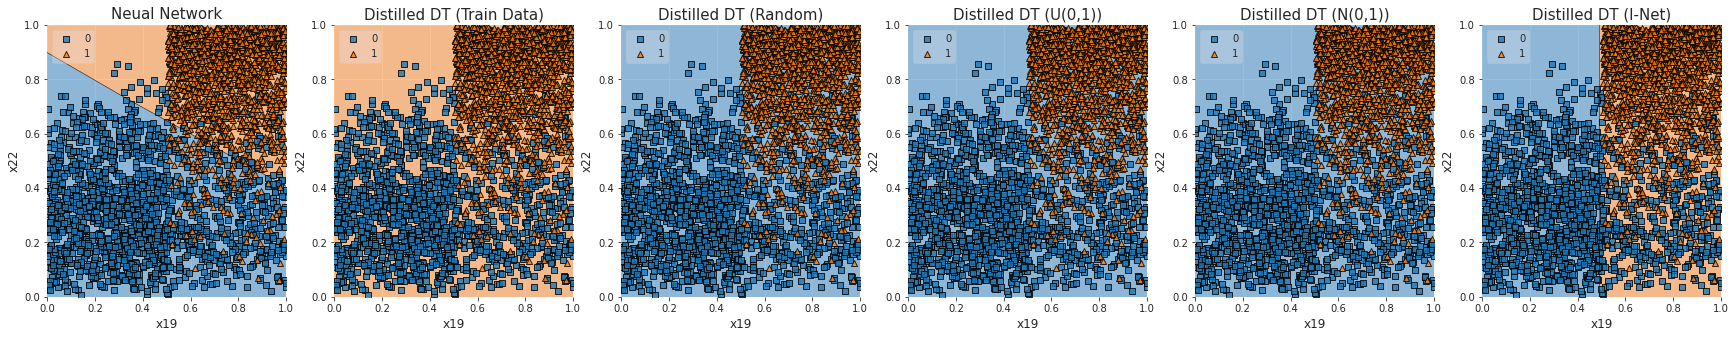

-----------------------------------------------------
Index:  2
Feature 1:  Samples 2576 / 2424
	 Distribution 1: uniform
		 low: 2.754
		 high: 3.541
	 Distribution 2: uniform
		 low: 2.312
		 high: 2.326
Feature 2:  Samples 765 / 4235
	 Distribution 1: poisson
		 lam: 2.191
	 Distribution 2: poisson
		 lam: 0.03
Considered Columns:								 0   3
Performance Network:								 0.982
Fidelity DT Sklearn Train Data:							 0.568
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.56
Fidelity DT Sklearn Uniform Data:						 0.536
Fidelity DT Sklearn Normal Data:						 0.536
Fidelity DT I-Net:								 0.81


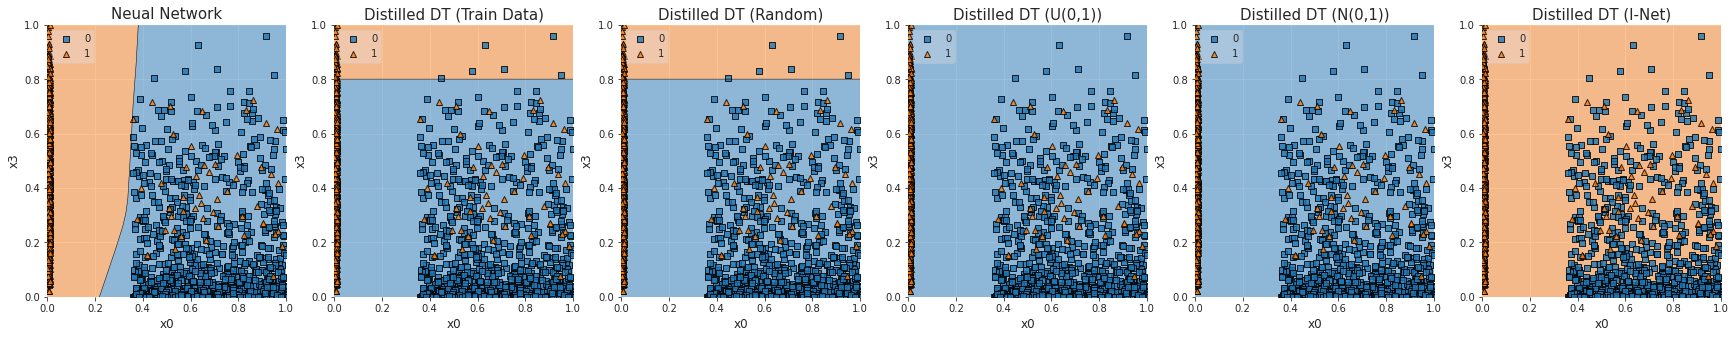

-----------------------------------------------------
Index:  0
Feature 1:  Samples 2733 / 2267
	 Distribution 1: uniform
		 low: 2.085
		 high: 3.602
	 Distribution 2: uniform
		 low: 1.932
		 high: 2.943
Feature 2:  Samples 3365 / 1635
	 Distribution 1: poisson
		 lam: 3.106
	 Distribution 2: poisson
		 lam: 1.49
Considered Columns:								 3   16
Performance Network:								 0.986
Fidelity DT Sklearn Train Data:							 0.62
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.536
Fidelity DT Sklearn Uniform Data:						 0.536
Fidelity DT Sklearn Normal Data:						 0.536
Fidelity DT I-Net:								 0.598


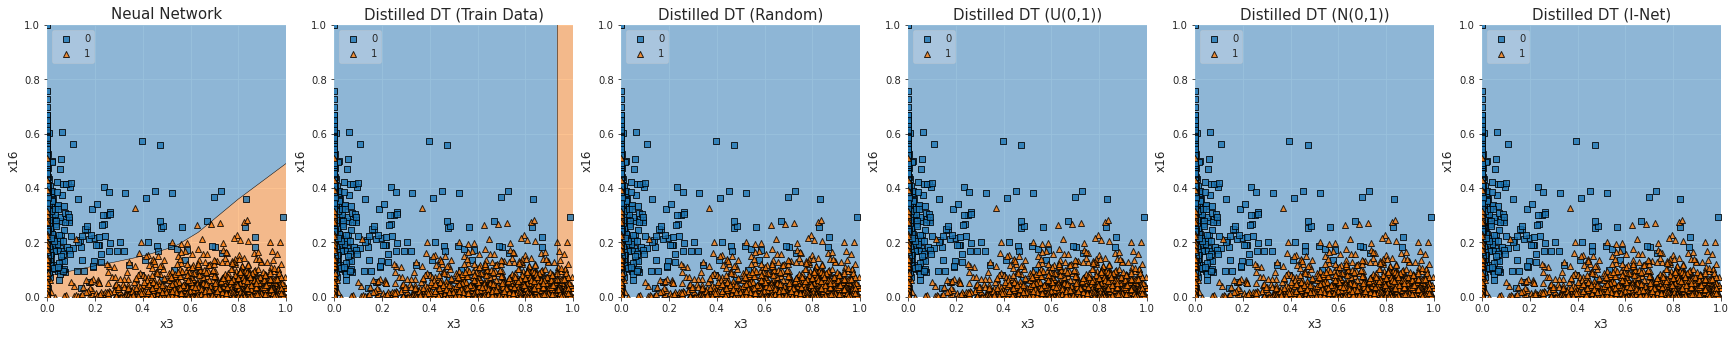

-----------------------------------------------------


In [29]:
if evaluate_distribution:
    timestr = time.strftime("%Y%m%d-%H%M%S")
    identifier_folder = config['function_family']['dt_type'] + '_' + str(config['function_family']['decision_sparsity']) + '_' + timestr
    os.makedirs('./data/distrib_plots/' + identifier_folder + '/', exist_ok=True)
    
    for i in range(min(3, test_size)):
        #index = 14
        #index = np.argmax(np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']) - np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy']))
        top_number = i
        #index = np.argsort(np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']) - np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy']))[::-1][top_number]

        scores_distilled_median_random = np.median(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0)
        scores_distilled_uniform = inet_evaluation_result_dict_complete_by_distribution_test[str(config['data']['distribution_list_eval'][0])]['dt_scores']['accuracy_uniform_data']
        scores_distilled_normal = inet_evaluation_result_dict_complete_by_distribution_test[str(config['data']['distribution_list_eval'][0])]['dt_scores']['accuracy_normal_data']
        
        scores_distilled_array = np.mean([scores_distilled_median_random, scores_distilled_uniform, scores_distilled_normal], axis=0)
        
        index = np.argsort(np.array(inet_evaluation_result_dict_complete_by_distribution_test[list(inet_evaluation_result_dict_complete_by_distribution_test.keys())[0]]['inet_scores']['accuracy']) - scores_distilled_array)[::-1][top_number]
        #index = np.argsort(np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']) - np.max(np.array([inet_evaluation_result_dict_complete_by_distribution_test[distrib]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0))[::-1][top_number]
        #index = np.argsort(np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']) - np.mean(np.array([inet_evaluation_result_dict_complete_by_distribution_test[distrib]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0))[::-1][top_number]

        distrib_for_index = np.argmax(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']])[:,index])

        print('Index: ', index)
        distribution_dict = distribution_parameter_list_list[index]

        print('Feature 1: ', 'Samples', distribution_dict[0][list(distribution_dict[0].keys())[0]]['samples_class_0'], '/', config['data']['lambda_dataset_size']-distribution_dict[0][list(distribution_dict[0].keys())[0]]['samples_class_0'])
        print('\t Distribution 1: ' + list(distribution_dict[0].keys())[0])
        for j, (distrib_parameter_name, distrib_parameter_value) in enumerate(distribution_dict[0][list(distribution_dict[0].keys())[0]]['class_0'].items()):
            print('\t\t '  + distrib_parameter_name +  ': ' + str(np.round(distrib_parameter_value, 3)))
        print('\t Distribution 2: ' + list(distribution_dict[0].keys())[0])
        for j, (distrib_parameter_name, distrib_parameter_value) in enumerate(distribution_dict[0][list(distribution_dict[0].keys())[0]]['class_1'].items()):
            print('\t\t '  + distrib_parameter_name +  ': ' + str(np.round(distrib_parameter_value, 3)))

        print('Feature 2: ', 'Samples', distribution_dict[1][list(distribution_dict[1].keys())[0]]['samples_class_0'], '/', config['data']['lambda_dataset_size']-distribution_dict[1][list(distribution_dict[1].keys())[0]]['samples_class_0'])
        print('\t Distribution 1: ' + list(distribution_dict[1].keys())[0])
        for j, (distrib_parameter_name, distrib_parameter_value) in enumerate(distribution_dict[1][list(distribution_dict[1].keys())[0]]['class_0'].items()):
            print('\t\t '  + distrib_parameter_name +  ': ' + str(np.round(distrib_parameter_value, 3)))
        print('\t Distribution 2: ' + list(distribution_dict[1].keys())[0])
        for j, (distrib_parameter_name, distrib_parameter_value) in enumerate(distribution_dict[1][list(distribution_dict[1].keys())[0]]['class_1'].items()):
            print('\t\t '  + distrib_parameter_name +  ': ' + str(np.round(distrib_parameter_value, 3)))

        identifier_file = 'index' + str(index) + '_' + '_'.join([list(dist.keys())[0] + '_' +  '_'.join([key + '-' + str(np.round(value, 4)) for key, value in dist[list(dist.keys())[0]]['class_0'].items()]) + '_' + '_'.join([key + '-' + str(np.round(value, 4)) for key, value in dist[list(dist.keys())[0]]['class_1'].items()]) for dist in distribution_parameter_list_list[index]])
        
        plot_decision_area_evaluation_all_distrib(data_dict_list_test[index]['X_train'], 
                                            data_dict_list_test[index]['y_train'], 
                                            data_dict_list_test[index]['X_test'], 
                                            data_dict_list_test[index]['y_test'],
                                            None,
                                            None,
                                            network_parameters_to_network(shaped_network_parameters_to_array(test_network_list_distrib[index], config), config),
                                            dt_distilled_list_test[0][index][-3],
                                            dt_distilled_list_test[0][index][-2],
                                            dt_distilled_list_test[0][index][-1],
                                            [dt_distilled_list_test[i][index][0] for i in range(len(config['data']['distribution_list_eval']))],     
                                            dt_inet_list_test[0][index],
                                            np.array([str(i) for i in range(data_dict_list_test[index]['X_train'].shape[1])]),
                                            config['data']['distribution_list_eval'],
                                            config,
                                            identifier_folder = identifier_folder,
                                            identifier_file = identifier_file
                                           )    



I-Net Decision Tree


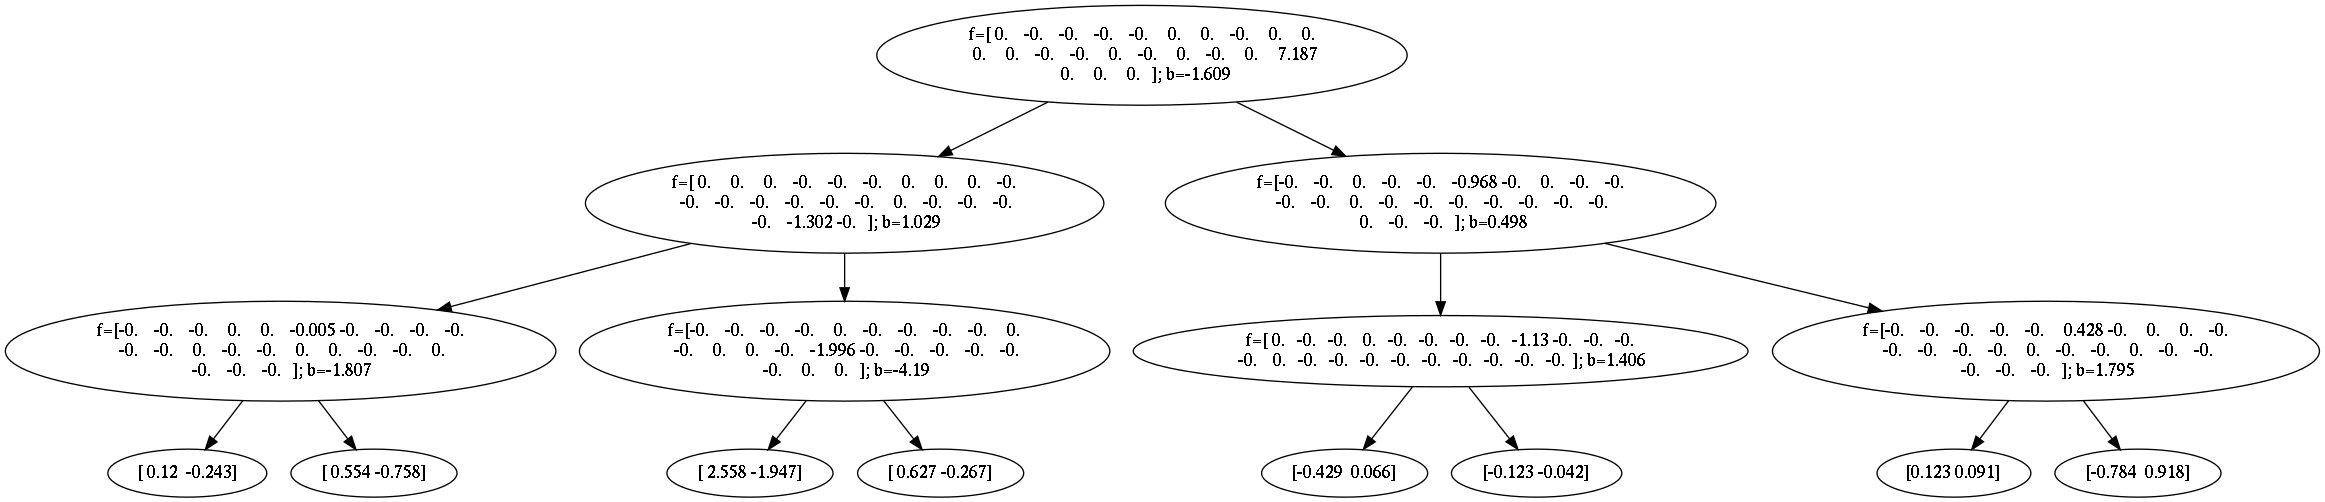

Random Data Decision Tree


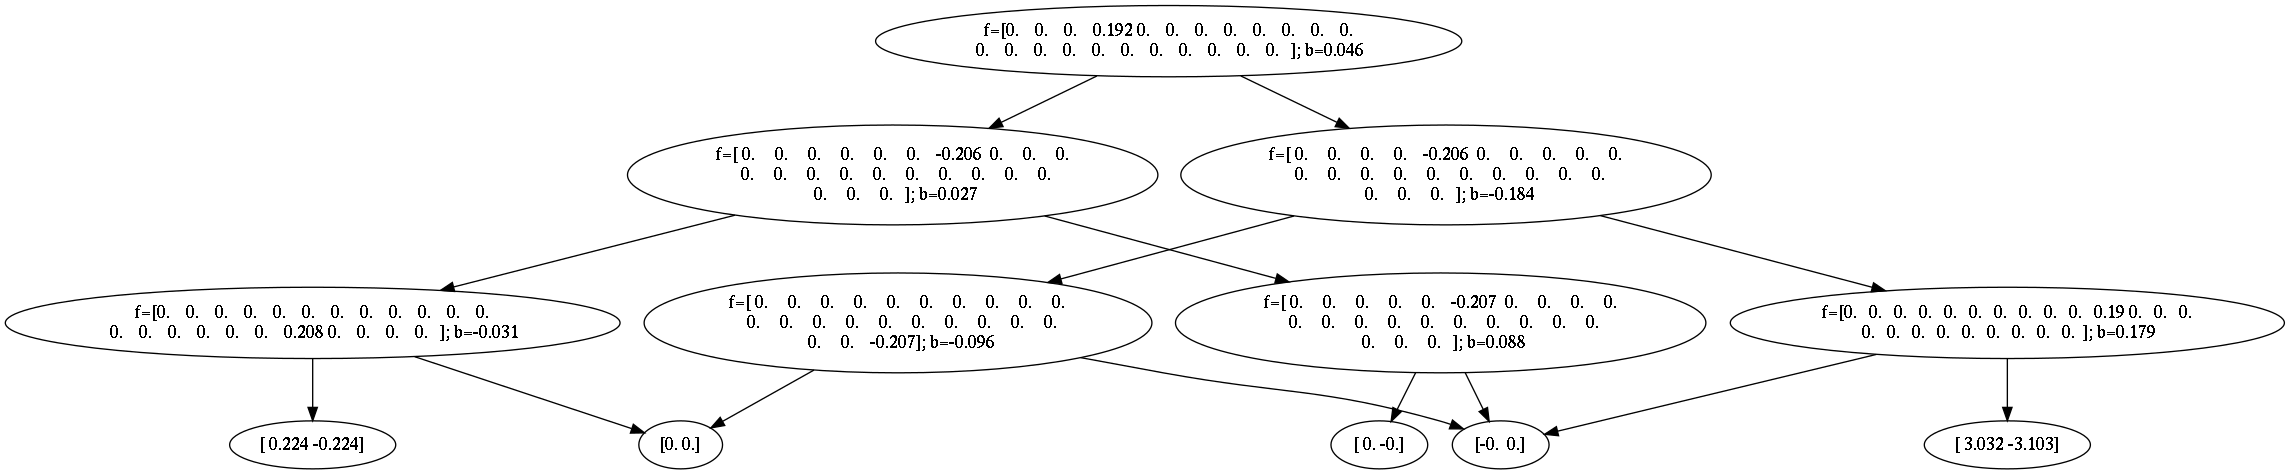

Train Data Decision Tree


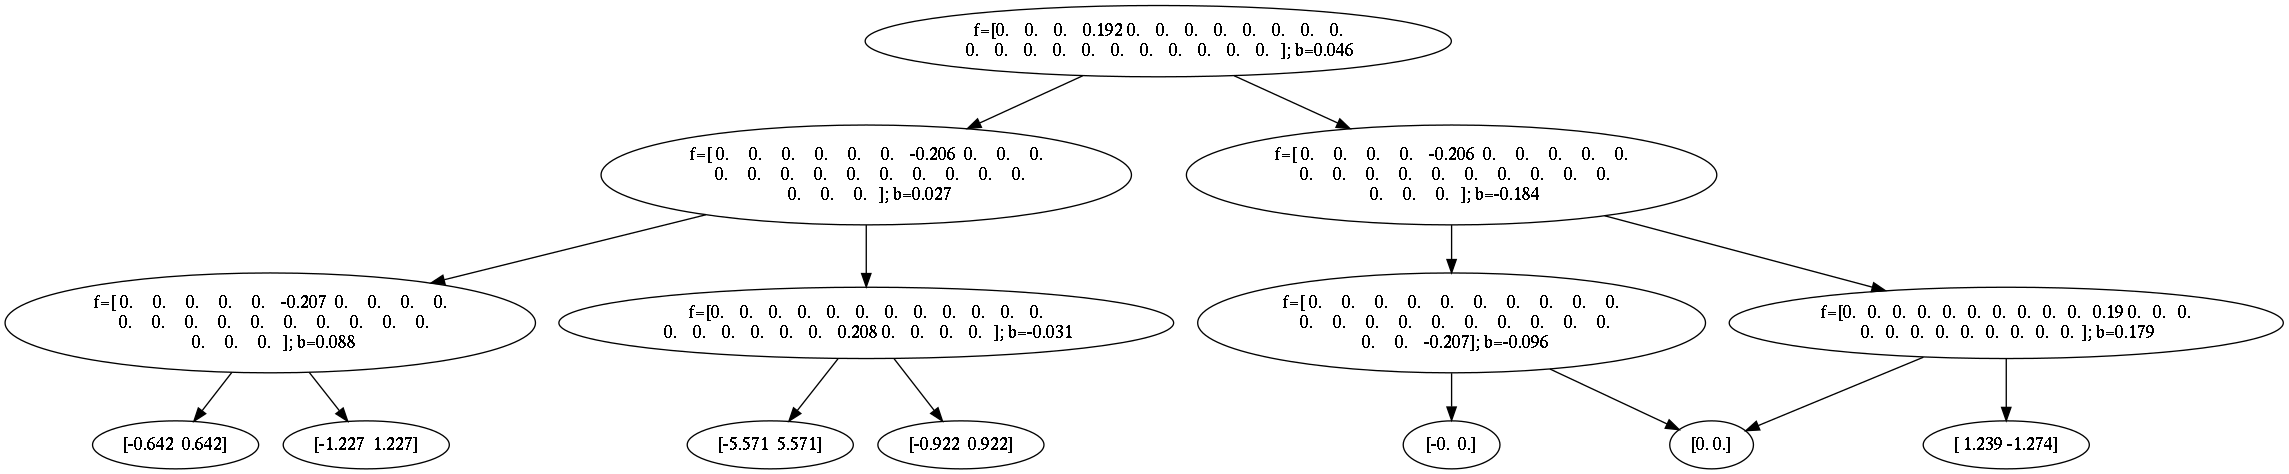

Uniform Data Decision Tree


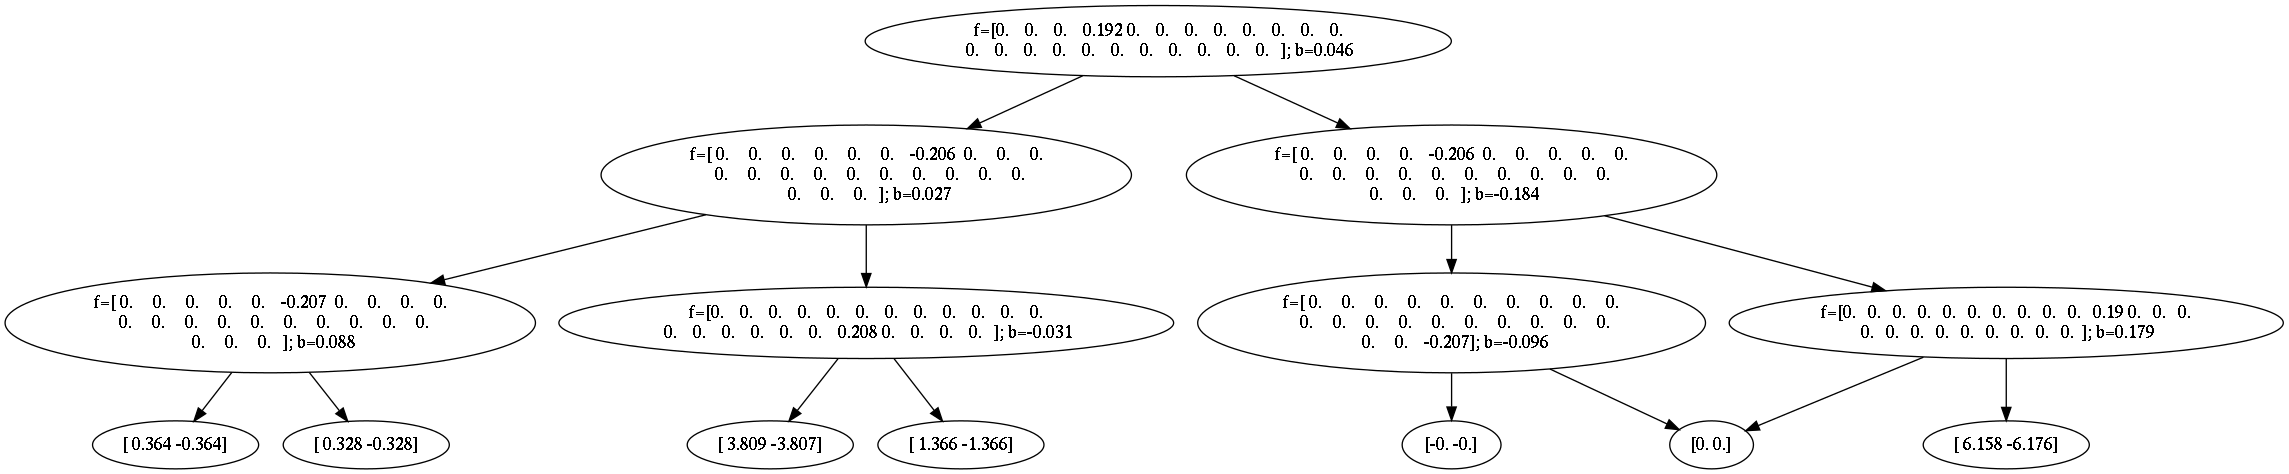

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

In [30]:
if config['function_family']['dt_type'] == 'vanilla':
    print('I-Net Decision Tree')
    plt.figure(figsize=(15,8))
    dt_inet = parameterDT(dt_inet_list_test[distrib_for_index][index], config)
    image = dt_inet.plot()
    display(image)
    
    print('Random Data Decision Tree')
    plt.figure(figsize=(15,8))
    plot_tree(dt_distilled_list_test[distrib_for_index][index][0], fontsize=10)  #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    plt.show()
    
    print('Train Data Decision Tree')
    plt.figure(figsize=(15,8))
    plot_tree(dt_distilled_list_test[distrib_for_index][index][1], fontsize=10)  #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    plt.show()    
    
    print('Uniform Data Decision Tree')
    plt.figure(figsize=(15,8))
    plot_tree(dt_distilled_list_test[distrib_for_index][index][2], fontsize=10)  #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    plt.show()    
else:
    print('I-Net Decision Tree')
    plt.figure(figsize=(15,8))
    dt_parameters = dt_inet_list_test[distrib_for_index][index]
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
    display(image)
    
    print('Random Data Decision Tree')
    plt.figure(figsize=(15,8))
    image = dt_distilled_list_test[distrib_for_index][index][0].plot_tree() #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    display(image)
    
    print('Train Data Decision Tree')
    plt.figure(figsize=(15,8)) 
    image = dt_distilled_list_test[distrib_for_index][index][1].plot_tree() #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL'] 
    display(image)
    
    print('Uniform Data Decision Tree')
    plt.figure(figsize=(15,8))
    image = dt_distilled_list_test[distrib_for_index][index][2].plot_tree() #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    display(image)

In [31]:
if False:
    plot_class_distrib_by_feature(model = model,
                                  index = index,
                                  test_network = network_parameters_to_network(lambda_net_dataset_valid.network_parameters_array[index], config, base_model=None),
                                  distribution_training = config['data']['distribution_list_eval'][distrib_for_index],
                                  distribution_dict = lambda_net_dataset_valid.distribution_dict_list_list[index],
                                  X_test = lambda_net_dataset_valid.X_test_lambda_array[index],
                                  config = config)

In [32]:
if False:
    plot_class_distrib_by_feature(model = model,
                                  index = index,
                                  test_network = network_parameters_to_network(shaped_network_parameters_to_array(test_network_list_distrib[index], config), config, base_model=None),
                                  distribution_training = config['data']['distribution_list_eval'][distrib_for_index],
                                  distribution_dict = lambda_net_dataset_valid.distribution_dict_list_list[index],
                                  X_test =  data_dict_list_test[0]['X_test'],
                                  config = config)

### Distribution Evaluation (Selected Samples)

In [33]:
#%load_ext autoreload
#%autoreload 2
if False:
    evaluate_network_on_distribution_custom_parameters(distribution_name_feature_0 = 'normal',
                                                       distribution_name_feature_1 = 'normal',
                                                       distribution_parameters_0_param_1_feature_0 = 1.188840288782265,
                                                       distribution_parameters_0_param_2_feature_0 = 0.8566173698593895,
                                                       distribution_parameters_1_param_1_feature_0 = 0.8713650102755661,
                                                       distribution_parameters_1_param_2_feature_0 = 1.8484540179178748,
                                                       distribution_parameters_0_param_1_feature_1 = 1.7185974826882278,
                                                       distribution_parameters_0_param_2_feature_1 = 0.5807878500034862,
                                                       distribution_parameters_1_param_1_feature_1 = 0.44369536008631294,
                                                       distribution_parameters_1_param_2_feature_1 = 1.17864258666672,
                                                       inet = model,
                                                       config = config,
                                                       distribution_list_evaluation = config['data']['distribution_list_eval'])


# Real-World Data Evaluation

In [34]:
#dataset_size_list = flatten_list([[config['evaluation']['random_evaluation_dataset_size_per_distribution']]*config['evaluation']['number_of_random_evaluations_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL'])
dataset_size_list = flatten_list([[config['evaluation']['random_evaluation_dataset_size_per_distribution']]*config['evaluation']['number_of_random_evaluations_per_distribution'], 
                                  'TRAINDATA', 
                                  ['STANDARDUNIFORM']*config['evaluation']['number_of_random_evaluations_per_distribution'], 
                                  ['STANDARDNORMAL']*config['evaluation']['number_of_random_evaluations_per_distribution']])


dataset_size_list_print = []
for size in dataset_size_list:
    if type(size) is int:
        size = size//1000
        size = str(size) + 'k'
        dataset_size_list_print.append(size)
    else:
        dataset_size_list_print.append(size)

In [35]:
#distances_dict = {}
evaluation_result_dict = {}
results_dict = {}
dt_inet_dict = {}
dt_distilled_list_dict = {}
data_dict = {}
normalizer_list_dict = {}
test_network_list = {}

identifier_list = []


## Titanic Dataset

In [36]:
titanic_data = pd.read_csv("./real_world_datasets/Titanic/train.csv")

titanic_data['Age'].fillna(titanic_data['Age'].mean(), inplace = True)
titanic_data['Fare'].fillna(titanic_data['Fare'].mean(), inplace = True)
    
titanic_data['Embarked'].fillna('S', inplace = True)

features_select = [
                    #'Cabin', 
                    #'Ticket', 
                    #'Name', 
                    #'PassengerId'    
                    'Sex',    
                    'Embarked',
                    'Pclass',
                    'Age',
                    'SibSp',    
                    'Parch',
                    'Fare',    
                    'Survived',    
                  ]

titanic_data = titanic_data[features_select]

nominal_features_titanic = ['Embarked']#[1, 2, 7]
ordinal_features_titanic = ['Sex']
    
X_data_titanic = titanic_data.drop(['Survived'], axis = 1)
y_data_titanic = titanic_data['Survived']


    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [37]:
identifier = 'Titanic'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_titanic, 
                                                                y_data_titanic, 
                                                                nominal_features = nominal_features_titanic, 
                                                                ordinal_features = ordinal_features_titanic,
                                                                config = config,
                                                                distribution_list_evaluation = config['data']['distribution_list_eval'],
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Original Data Shape (selected):  (891, 7)
Original Data Shape (encoded):  (891, 9)
Original Data Class Distribution:  342  (true) / 549  (false)


In [38]:
if test_network_list[identifier] is not None:
    plot_decision_area_evaluation_all_distrib(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                None,
                                None,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAINDATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('STANDARDUNIFORM')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('STANDARDNORMAL')],
                                [dt_distilled_list_dict[identifier][0][dataset_size_list.index(config['evaluation']['random_evaluation_dataset_size_per_distribution'])]],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config['data']['distribution_list_eval'],
                                config
                               )

In [39]:
if test_network_list[identifier] is not None:
    for index, (var_name, feature_name) in enumerate(zip(['x'+str(i) for i in range(len(data_dict[identifier]['X_train'].columns))], list(data_dict[identifier]['X_train'].columns))):
        scale_feature = normalizer_list_dict[identifier][index].scale_[0]
        print(var_name, '=', feature_name, '(Scale: ' +  str(scale_feature) + ')')
        
    acc_list = [results_dict[identifier][i]['dt_scores']['accuracy_' + str(distribution_list_eval[0])] for i in range(max(loc for loc, val in enumerate(dataset_size_list) if val == dataset_size_list[0]))]
    idx_min = np.argsort(acc_list)[0]#[len(acc_list)//2]
    idx_uniform = dataset_size_list.index('STANDARDUNIFORM')
    idx_train = dataset_size_list.index('TRAINDATA')
    
    print('\n')
    if config['function_family']['dt_type'] == 'vanilla':
        print('Accuracy Distilled Train', results_dict[identifier][idx_train]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train', results_dict[identifier][idx_train]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_train], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()
        
        print('Accuracy I-Net', results_dict[identifier][idx_min]['inet_scores']['accuracy'])
        print('F1-Score  I-Net', results_dict[identifier][idx_min]['inet_scores']['f1_score'])
        plt.figure(figsize=(15,8))
        dt_inet = parameterDT(dt_inet_dict[identifier], config, normalizer_list=normalizer_list_dict[identifier])
        image = dt_inet.plot()
        display(image)
        
        print('Accuracy Distilled Random', results_dict[identifier][idx_min]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random', results_dict[identifier][idx_min]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_min], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()
        
        print('Accuracy Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_uniform], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()      

 
    else:
        print('Accuracy Distilled Train', results_dict[identifier][idx_train]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train', results_dict[identifier][idx_train]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_train].plot_tree()
        display(image)
        
        print('Accuracy I-Net', results_dict[identifier][idx_min]['inet_scores']['accuracy'])
        print('F1-Score  I-Net', results_dict[identifier][idx_min]['inet_scores']['f1_score'])
        plt.figure(figsize=(15,8))
        dt_parameters = dt_inet_dict[identifier]
        tree = generate_random_decision_tree(config)
        tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
        image = tree.plot_tree()
        display(image)

        print('Accuracy Distilled Random', results_dict[identifier][idx_min]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random', results_dict[identifier][idx_min]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_min].plot_tree()
        display(image)
        
        print('Accuracy Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_uniform].plot_tree()
        display(image)     
    
    y_train = data_dict[identifier]['y_train']
    y_train_pred = pd.Series(np.round(test_network_list[identifier].predict(data_dict[identifier]['X_train'])).ravel(), 
                             name="Survived")
    X_data = pd.concat([data_dict[identifier]['X_train'], y_train_pred], axis=1)
    display(X_data.head())
    
    X_data.groupby("Survived").SibSp.hist(alpha=0.6)
    plt.show()
    #X_data[X_data.Parch > 0.8].groupby("Survived").Age.hist(alpha=0.6)
    #plt.show()
    X_data.groupby("Survived").Age.hist(alpha=0.6)
    plt.show()
    X_data.groupby("Survived").Sex.hist(alpha=0.6)
    plt.show()
    
    
    uniform_data = generate_random_data_points_custom(config['data']['x_min'], 
                                   config['data']['x_max'],
                                   config['evaluation']['random_evaluation_dataset_size_per_distribution'], 
                                   config['data']['number_of_variables'], 
                                   config['data']['categorical_indices'],
                                   distrib='standarduniform',
                                   random_parameters=config['data']['random_parameters_distribution'],
                                   distrib_param_max=config['data']['distrib_param_max'],
                                   seed=config['computation']['RANDOM_SEED'],
                                   config=config)    
    
    y_uniform_data = np.round(test_network_list[identifier].predict(uniform_data))

    uniform_data_with_labels_df = pd.DataFrame(data=np.hstack([uniform_data, y_uniform_data]), columns=X_data.columns)    
    
    uniform_data_with_labels_df.groupby("Survived").SibSp.hist(alpha=0.6)
    plt.show()
    uniform_data_with_labels_df[uniform_data_with_labels_df.SibSp > 0.56].groupby("Survived").Age.hist(alpha=0.6)
    plt.show()
    uniform_data_with_labels_df[uniform_data_with_labels_df.SibSp < 0.56].groupby("Survived").Age.hist(alpha=0.6)
    plt.show()    
    
    uniform_data_with_labels_df.groupby("Survived").Age.hist(alpha=0.6)
    plt.show()
    uniform_data_with_labels_df.groupby("Survived").Sex.hist(alpha=0.6)
    plt.show()        
    
            

## Loan House

In [40]:
loan_data = pd.read_csv('real_world_datasets/Loan/loan-train.csv', delimiter=',')

loan_data['Gender'].fillna(loan_data['Gender'].mode()[0], inplace=True)
loan_data['Dependents'].fillna(loan_data['Dependents'].mode()[0], inplace=True)
loan_data['Married'].fillna(loan_data['Married'].mode()[0], inplace=True)
loan_data['Self_Employed'].fillna(loan_data['Self_Employed'].mode()[0], inplace=True)
loan_data['LoanAmount'].fillna(loan_data['LoanAmount'].mean(), inplace=True)
loan_data['Loan_Amount_Term'].fillna(loan_data['Loan_Amount_Term'].mean(), inplace=True)
loan_data['Credit_History'].fillna(loan_data['Credit_History'].mean(), inplace=True)

features_select = [
                    #'Loan_ID', 
                    'Gender', #
                    'Married', 
                    'Dependents', 
                    'Education',
                    'Self_Employed', 
                    'ApplicantIncome', 
                    'CoapplicantIncome', 
                    'LoanAmount',
                    'Loan_Amount_Term', 
                    'Credit_History', 
                    'Property_Area', 
                    'Loan_Status'
                    ]

loan_data = loan_data[features_select]

#loan_data['Dependents'][loan_data['Dependents'] == '3+'] = 4
#loan_data['Dependents'] = loan_data['Dependents'].astype(int)

#loan_data['Property_Area'][loan_data['Property_Area'] == 'Rural'] = 0
#loan_data['Property_Area'][loan_data['Property_Area'] == 'Semiurban'] = 1
#loan_data['Property_Area'][loan_data['Property_Area'] == 'Urban'] = 2
#loan_data['Property_Area'] = loan_data['Property_Area'].astype(int)

nominal_features_loan = [
                        'Dependents',
                        'Property_Area',    
                        ]


ordinal_features_loan = [
                    'Education',
                    'Gender', 
                    'Married', 
                    'Self_Employed',
                   ]
    
X_data_loan = loan_data.drop(['Loan_Status'], axis = 1)
y_data_loan = ((loan_data['Loan_Status'] == 'Y') * 1) 

In [41]:
config_train_network_loan_house = deepcopy(config)
#config_train_network_loan_house['lambda_net']['batch_lambda'] = 64#16
#config_train_network_loan_house['lambda_net']['learning_rate_lambda'] = 0.001
#config_train_network_loan_house['lambda_net']['dropout_lambda'] = 0#.1
#config_train_network_loan_house['lambda_net']['epochs_lambda'] = 500
#config_train_network_loan_house['lambda_net']['optimizer_lambda'] = 'adam'


In [42]:
identifier = 'Loan House'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_loan, 
                                                                y_data_loan, 
                                                                nominal_features = nominal_features_loan, 
                                                                ordinal_features = ordinal_features_loan,
                                                                #config = config_train_network_loan_house,
                                                                config = config,
                                                                distribution_list_evaluation = config['data']['distribution_list_eval'],
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Original Data Shape (selected):  (614, 11)
Original Data Shape (encoded):  (614, 16)
Original Data Class Distribution:  422  (true) / 192  (false)


In [43]:
if test_network_list[identifier] is not None:
    plot_decision_area_evaluation_all_distrib(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                None,
                                None,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAINDATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('STANDARDUNIFORM')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('STANDARDNORMAL')],
                                [dt_distilled_list_dict[identifier][0][dataset_size_list.index(config['evaluation']['random_evaluation_dataset_size_per_distribution'])]],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config['data']['distribution_list_eval'],
                                config
                               )

In [44]:
if test_network_list[identifier] is not None:
    for index, (var_name, feature_name) in enumerate(zip(['x'+str(i) for i in range(len(data_dict[identifier]['X_train'].columns))], list(data_dict[identifier]['X_train'].columns))):
        scale_feature = normalizer_list_dict[identifier][index].scale_[0]
        print(var_name, '=', feature_name, '(Scale: ' +  str(scale_feature) + ')')
        
    acc_list = [results_dict[identifier][i]['dt_scores']['accuracy_' + str(distribution_list_eval[0])] for i in range(max(loc for loc, val in enumerate(dataset_size_list) if val == dataset_size_list[0]))]
    idx_min = np.argsort(acc_list)[0]#[len(acc_list)//2]
    idx_uniform = dataset_size_list.index('STANDARDUNIFORM')
    idx_train = dataset_size_list.index('TRAINDATA')
    
    print('\n')
    if config['function_family']['dt_type'] == 'vanilla':
        print('Accuracy Distilled Train', results_dict[identifier][idx_train]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train', results_dict[identifier][idx_train]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_train], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()
        
        print('Accuracy I-Net', results_dict[identifier][idx_min]['inet_scores']['accuracy'])
        print('F1-Score  I-Net', results_dict[identifier][idx_min]['inet_scores']['f1_score'])
        plt.figure(figsize=(15,8))
        dt_inet = parameterDT(dt_inet_dict[identifier], config, normalizer_list=normalizer_list_dict[identifier])
        image = dt_inet.plot()
        display(image)
        
        print('Accuracy Distilled Random', results_dict[identifier][idx_min]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random', results_dict[identifier][idx_min]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_min], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()
        
        print('Accuracy Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_uniform], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()      

 
    else:
        print('Accuracy Distilled Train', results_dict[identifier][idx_train]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train', results_dict[identifier][idx_train]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_train].plot_tree()
        display(image)
        
        print('Accuracy I-Net', results_dict[identifier][idx_min]['inet_scores']['accuracy'])
        print('F1-Score  I-Net', results_dict[identifier][idx_min]['inet_scores']['f1_score'])
        plt.figure(figsize=(15,8))
        dt_parameters = dt_inet_dict[identifier]
        tree = generate_random_decision_tree(config)
        tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
        image = tree.plot_tree()
        display(image)

        print('Accuracy Distilled Random', results_dict[identifier][idx_min]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random', results_dict[identifier][idx_min]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_min].plot_tree()
        display(image)
        
        print('Accuracy Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_uniform].plot_tree()
        display(image)     

## Medical Insurance

In [45]:
medical_insurance_data = pd.read_csv('real_world_datasets/Medical Insurance/insurance.csv', delimiter=',')

features_select = [
                    'age', 
                    'sex', 
                    'bmi', 
                    'children', 
                    'smoker',
                    'region',
                    'charges'
                    ]

medical_insurance_data = medical_insurance_data[features_select]

nominal_features_medical_insurance = [
                    'region',
                        ]
ordinal_features_medical_insurance = [
                    'sex',
                    'smoker'
                   ]

    
X_data_medical_insurance = medical_insurance_data.drop(['charges'], axis = 1)
y_data_medical_insurance = ((medical_insurance_data['charges'] > 10_000) * 1)

X_data_medical_insurance.head()


,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [46]:
identifier = 'Medical Insurance'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_medical_insurance, 
                                                                y_data_medical_insurance, 
                                                                nominal_features = nominal_features_medical_insurance, 
                                                                ordinal_features = ordinal_features_medical_insurance,
                                                                config = config,
                                                                distribution_list_evaluation = config['data']['distribution_list_eval'],
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Original Data Shape (selected):  (1338, 6)
Original Data Shape (encoded):  (1338, 9)
Original Data Class Distribution:  626  (true) / 712  (false)


In [47]:
if test_network_list[identifier] is not None:
    plot_decision_area_evaluation_all_distrib(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                None,
                                None,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAINDATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('STANDARDUNIFORM')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('STANDARDNORMAL')],
                                [dt_distilled_list_dict[identifier][0][dataset_size_list.index(config['evaluation']['random_evaluation_dataset_size_per_distribution'])]],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config['data']['distribution_list_eval'],
                                config
                               )

In [48]:
if test_network_list[identifier] is not None:
    for index, (var_name, feature_name) in enumerate(zip(['x'+str(i) for i in range(len(data_dict[identifier]['X_train'].columns))], list(data_dict[identifier]['X_train'].columns))):
        scale_feature = normalizer_list_dict[identifier][index].scale_[0]
        print(var_name, '=', feature_name, '(Scale: ' +  str(scale_feature) + ')')
        
    acc_list = [results_dict[identifier][i]['dt_scores']['accuracy_' + str(distribution_list_eval[0])] for i in range(max(loc for loc, val in enumerate(dataset_size_list) if val == dataset_size_list[0]))]
    idx_min = np.argsort(acc_list)[0]#[len(acc_list)//2]
    idx_uniform = dataset_size_list.index('STANDARDUNIFORM')
    idx_train = dataset_size_list.index('TRAINDATA')
    
    print('\n')
    if config['function_family']['dt_type'] == 'vanilla':
        print('Accuracy Distilled Train', results_dict[identifier][idx_train]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train', results_dict[identifier][idx_train]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_train], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()
        
        print('Accuracy I-Net', results_dict[identifier][idx_min]['inet_scores']['accuracy'])
        print('F1-Score  I-Net', results_dict[identifier][idx_min]['inet_scores']['f1_score'])
        plt.figure(figsize=(15,8))
        dt_inet = parameterDT(dt_inet_dict[identifier], config, normalizer_list=normalizer_list_dict[identifier])
        image = dt_inet.plot()
        display(image)
        
        print('Accuracy Distilled Random', results_dict[identifier][idx_min]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random', results_dict[identifier][idx_min]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_min], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()
        
        print('Accuracy Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_uniform], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()      

 
    else:
        print('Accuracy Distilled Train', results_dict[identifier][idx_train]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train', results_dict[identifier][idx_train]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_train].plot_tree()
        display(image)
        
        print('Accuracy I-Net', results_dict[identifier][idx_min]['inet_scores']['accuracy'])
        print('F1-Score  I-Net', results_dict[identifier][idx_min]['inet_scores']['f1_score'])
        plt.figure(figsize=(15,8))
        dt_parameters = dt_inet_dict[identifier]
        tree = generate_random_decision_tree(config)
        tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
        image = tree.plot_tree()
        display(image)

        print('Accuracy Distilled Random', results_dict[identifier][idx_min]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random', results_dict[identifier][idx_min]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_min].plot_tree()
        display(image)
        
        print('Accuracy Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_uniform].plot_tree()
        display(image)     

## Cervical cancer (Risk Factors) Data Set

In [49]:
cc_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv', index_col=False)#, names=feature_names

features_select = [
                    'Age',
                    'Number of sexual partners',
                    'First sexual intercourse',
                    'Num of pregnancies',
                    'Smokes',
                    'Smokes (years)',
                    'Hormonal Contraceptives',
                    'Hormonal Contraceptives (years)',
                    'IUD',
                    'IUD (years)',
                    'STDs',
                    'STDs (number)',
                    'STDs: Number of diagnosis',
                    'STDs: Time since first diagnosis',
                    'STDs: Time since last diagnosis',
                    'Biopsy'
                    ]

cc_data = cc_data[features_select]

cc_data['Number of sexual partners'][cc_data['Number of sexual partners'] == '?'] = cc_data['Number of sexual partners'].mode()[0]
cc_data['First sexual intercourse'][cc_data['First sexual intercourse'] == '?'] = cc_data['First sexual intercourse'].mode()[0]
cc_data['Num of pregnancies'][cc_data['Num of pregnancies'] == '?'] = cc_data['Num of pregnancies'].mode()[0]
cc_data['Smokes'][cc_data['Smokes'] == '?'] = cc_data['Smokes'].mode()[0]
cc_data['Smokes (years)'][cc_data['Smokes (years)'] == '?'] = cc_data['Smokes (years)'].mode()[0]
cc_data['Hormonal Contraceptives'][cc_data['Hormonal Contraceptives'] == '?'] = cc_data['Hormonal Contraceptives'].mode()[0]
cc_data['Hormonal Contraceptives (years)'][cc_data['Hormonal Contraceptives (years)'] == '?'] = cc_data['Hormonal Contraceptives (years)'].mode()[0]
cc_data['IUD'][cc_data['IUD'] == '?'] = cc_data['IUD'].mode()[0]
cc_data['IUD (years)'][cc_data['IUD (years)'] == '?'] = cc_data['IUD (years)'].mode()[0]
cc_data['STDs'][cc_data['STDs'] == '?'] = cc_data['STDs'].mode()[0]
cc_data['STDs (number)'][cc_data['STDs (number)'] == '?'] = cc_data['STDs (number)'].mode()[0]
cc_data['STDs: Time since first diagnosis'][cc_data['STDs: Time since first diagnosis'] == '?'] = cc_data['STDs: Time since first diagnosis'][cc_data['STDs: Time since first diagnosis'] != '?'].mode()[0]
cc_data['STDs: Time since last diagnosis'][cc_data['STDs: Time since last diagnosis'] == '?'] = cc_data['STDs: Time since last diagnosis'][cc_data['STDs: Time since last diagnosis'] != '?'].mode()[0]

nominal_features_cc = [
                        ]
ordinal_features_cc = [
                   ]

    
X_data_cc = cc_data.drop(['Biopsy'], axis = 1)
y_data_cc = pd.Series(OrdinalEncoder().fit_transform(cc_data['Biopsy'].values.reshape(-1, 1)).flatten(), name='Biopsy')


In [50]:
identifier = 'Cervical Cancer'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_cc, 
                                                                y_data_cc, 
                                                                nominal_features = nominal_features_cc, 
                                                                ordinal_features = ordinal_features_cc,
                                                                config = config,
                                                                distribution_list_evaluation = config['data']['distribution_list_eval'],
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Original Data Shape (selected):  (858, 15)
Original Data Shape (encoded):  (858, 15)
Original Data Class Distribution:  55  (true) / 803  (false)


In [51]:
if test_network_list[identifier] is not None:
    plot_decision_area_evaluation_all_distrib(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                None,
                                None,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAINDATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('STANDARDUNIFORM')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('STANDARDNORMAL')],
                                [dt_distilled_list_dict[identifier][0][dataset_size_list.index(config['evaluation']['random_evaluation_dataset_size_per_distribution'])]],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config['data']['distribution_list_eval'],
                                config
                               )

In [52]:
if test_network_list[identifier] is not None:
    for index, (var_name, feature_name) in enumerate(zip(['x'+str(i) for i in range(len(data_dict[identifier]['X_train'].columns))], list(data_dict[identifier]['X_train'].columns))):
        scale_feature = normalizer_list_dict[identifier][index].scale_[0]
        print(var_name, '=', feature_name, '(Scale: ' +  str(scale_feature) + ')')
        
    acc_list = [results_dict[identifier][i]['dt_scores']['accuracy_' + str(distribution_list_eval[0])] for i in range(max(loc for loc, val in enumerate(dataset_size_list) if val == dataset_size_list[0]))]
    idx_min = np.argsort(acc_list)[0]#[len(acc_list)//2]
    idx_uniform = dataset_size_list.index('STANDARDUNIFORM')
    idx_train = dataset_size_list.index('TRAINDATA')
    
    print('\n')
    if config['function_family']['dt_type'] == 'vanilla':
        print('Accuracy Distilled Train', results_dict[identifier][idx_train]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train', results_dict[identifier][idx_train]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_train], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()
        
        print('Accuracy I-Net', results_dict[identifier][idx_min]['inet_scores']['accuracy'])
        print('F1-Score  I-Net', results_dict[identifier][idx_min]['inet_scores']['f1_score'])
        plt.figure(figsize=(15,8))
        dt_inet = parameterDT(dt_inet_dict[identifier], config, normalizer_list=normalizer_list_dict[identifier])
        image = dt_inet.plot()
        display(image)
        
        print('Accuracy Distilled Random', results_dict[identifier][idx_min]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random', results_dict[identifier][idx_min]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_min], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()
        
        print('Accuracy Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_uniform], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()      

 
    else:
        print('Accuracy Distilled Train', results_dict[identifier][idx_train]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train', results_dict[identifier][idx_train]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_train].plot_tree()
        display(image)
        
        print('Accuracy I-Net', results_dict[identifier][idx_min]['inet_scores']['accuracy'])
        print('F1-Score  I-Net', results_dict[identifier][idx_min]['inet_scores']['f1_score'])
        plt.figure(figsize=(15,8))
        dt_parameters = dt_inet_dict[identifier]
        tree = generate_random_decision_tree(config)
        tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
        image = tree.plot_tree()
        display(image)

        print('Accuracy Distilled Random', results_dict[identifier][idx_min]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random', results_dict[identifier][idx_min]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_min].plot_tree()
        display(image)
        
        print('Accuracy Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_uniform].plot_tree()
        display(image)     

## Brest Cancer Wisconsin

In [53]:
feature_names = [
                'Sample code number',
                'Clump Thickness',
                'Uniformity of Cell Size',
                'Uniformity of Cell Shape',
                'Marginal Adhesion',
                'Single Epithelial Cell Size',
                'Bare Nuclei',
                'Bland Chromatin',
                'Normal Nucleoli',
                'Mitoses',
                'Class',
                ]

bcw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', names=feature_names, index_col=False)

bcw_data['Clump Thickness'][bcw_data['Clump Thickness'] == '?'] = bcw_data['Clump Thickness'].mode()[0]
bcw_data['Uniformity of Cell Size'][bcw_data['Uniformity of Cell Size'] == '?'] = bcw_data['Uniformity of Cell Size'].mode()[0]
bcw_data['Uniformity of Cell Shape'][bcw_data['Uniformity of Cell Shape'] == '?'] = bcw_data['Uniformity of Cell Shape'].mode()[0]
bcw_data['Marginal Adhesion'][bcw_data['Marginal Adhesion'] == '?'] = bcw_data['Marginal Adhesion'].mode()[0]
bcw_data['Single Epithelial Cell Size'][bcw_data['Single Epithelial Cell Size'] == '?'] = bcw_data['Single Epithelial Cell Size'].mode()[0]
bcw_data['Bare Nuclei'][bcw_data['Bare Nuclei'] == '?'] = bcw_data['Bare Nuclei'].mode()[0]
bcw_data['Bland Chromatin'][bcw_data['Bland Chromatin'] == '?'] = bcw_data['Bland Chromatin'].mode()[0]
bcw_data['Normal Nucleoli'][bcw_data['Normal Nucleoli'] == '?'] = bcw_data['Normal Nucleoli'].mode()[0]
bcw_data['Mitoses'][bcw_data['Mitoses'] == '?'] = bcw_data['Mitoses'].mode()[0]

features_select = [
                #'Sample code number',
                'Clump Thickness',
                'Uniformity of Cell Size',
                'Uniformity of Cell Shape',
                'Marginal Adhesion',
                'Single Epithelial Cell Size',
                'Bare Nuclei',
                'Bland Chromatin',
                'Normal Nucleoli',
                'Mitoses',
                'Class',
                    ]

bcw_data = bcw_data[features_select]

nominal_features_bcw = [
                        ]
ordinal_features_bcw = [
                   ]

    
X_data_bcw = bcw_data.drop(['Class'], axis = 1)
y_data_bcw = pd.Series(OrdinalEncoder().fit_transform(bcw_data['Class'].values.reshape(-1, 1)).flatten(), name='Class')


In [54]:
identifier = 'Brest Cancer Wisconsin'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_bcw, 
                                                                y_data_bcw, 
                                                                nominal_features = nominal_features_bcw, 
                                                                ordinal_features = ordinal_features_bcw,
                                                                config = config,
                                                                distribution_list_evaluation = config['data']['distribution_list_eval'],
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Original Data Shape (selected):  (699, 9)
Original Data Shape (encoded):  (699, 9)
Original Data Class Distribution:  241  (true) / 458  (false)


In [55]:
if test_network_list[identifier] is not None:
    plot_decision_area_evaluation_all_distrib(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                None,
                                None,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAINDATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('STANDARDUNIFORM')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('STANDARDNORMAL')],
                                [dt_distilled_list_dict[identifier][0][dataset_size_list.index(config['evaluation']['random_evaluation_dataset_size_per_distribution'])]],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config['data']['distribution_list_eval'],
                                config
                               )

In [56]:
if test_network_list[identifier] is not None:
    for index, (var_name, feature_name) in enumerate(zip(['x'+str(i) for i in range(len(data_dict[identifier]['X_train'].columns))], list(data_dict[identifier]['X_train'].columns))):
        scale_feature = normalizer_list_dict[identifier][index].scale_[0]
        print(var_name, '=', feature_name, '(Scale: ' +  str(scale_feature) + ')')
        
    acc_list = [results_dict[identifier][i]['dt_scores']['accuracy_' + str(distribution_list_eval[0])] for i in range(max(loc for loc, val in enumerate(dataset_size_list) if val == dataset_size_list[0]))]
    idx_min = np.argsort(acc_list)[0]#[len(acc_list)//2]
    idx_uniform = dataset_size_list.index('STANDARDUNIFORM')
    idx_train = dataset_size_list.index('TRAINDATA')
    
    print('\n')
    if config['function_family']['dt_type'] == 'vanilla':
        print('Accuracy Distilled Train', results_dict[identifier][idx_train]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train', results_dict[identifier][idx_train]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_train], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()
        
        print('Accuracy I-Net', results_dict[identifier][idx_min]['inet_scores']['accuracy'])
        print('F1-Score  I-Net', results_dict[identifier][idx_min]['inet_scores']['f1_score'])
        plt.figure(figsize=(15,8))
        dt_inet = parameterDT(dt_inet_dict[identifier], config, normalizer_list=normalizer_list_dict[identifier])
        image = dt_inet.plot()
        display(image)
        
        print('Accuracy Distilled Random', results_dict[identifier][idx_min]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random', results_dict[identifier][idx_min]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_min], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()
        
        print('Accuracy Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_uniform], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()      

 
    else:
        print('Accuracy Distilled Train', results_dict[identifier][idx_train]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train', results_dict[identifier][idx_train]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_train].plot_tree()
        display(image)
        
        print('Accuracy I-Net', results_dict[identifier][idx_min]['inet_scores']['accuracy'])
        print('F1-Score  I-Net', results_dict[identifier][idx_min]['inet_scores']['f1_score'])
        plt.figure(figsize=(15,8))
        dt_parameters = dt_inet_dict[identifier]
        tree = generate_random_decision_tree(config)
        tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
        image = tree.plot_tree()
        display(image)

        print('Accuracy Distilled Random', results_dict[identifier][idx_min]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random', results_dict[identifier][idx_min]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_min].plot_tree()
        display(image)
        
        print('Accuracy Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_uniform].plot_tree()
        display(image)     

## Wisconsin Diagnostic Breast Cancer

In [57]:
feature_names = [
                'ID number',
                'Diagnosis',
                'radius',# (mean of distances from center to points on the perimeter)
                'texture',# (standard deviation of gray-scale values)
                'perimeter',
                'area',
                'smoothness',# (local variation in radius lengths)
                'compactness',# (perimeter^2 / area - 1.0)
                'concavity',# (severity of concave portions of the contour)
                'concave points',# (number of concave portions of the contour)
                'symmetry',
                'fractal dimension',# ("coastline approximation" - 1)
                ]
#Wisconsin Diagnostic Breast Cancer
wdbc_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', names=feature_names, index_col=False)

features_select = [
                    #'ID number',
                    'Diagnosis',
                    'radius',# (mean of distances from center to points on the perimeter)
                    'texture',# (standard deviation of gray-scale values)
                    'perimeter',
                    'area',
                    'smoothness',# (local variation in radius lengths)
                    'compactness',# (perimeter^2 / area - 1.0)
                    'concavity',# (severity of concave portions of the contour)
                    'concave points',# (number of concave portions of the contour)
                    'symmetry',
                    'fractal dimension',# ("coastline approximation" - 1)
                    ]

wdbc_data = wdbc_data[features_select]

nominal_features_wdbc = [
                        ]
ordinal_features_wdbc = [
                   ]

    
X_data_wdbc = wdbc_data.drop(['Diagnosis'], axis = 1)
y_data_wdbc= pd.Series(OrdinalEncoder().fit_transform(wdbc_data['Diagnosis'].values.reshape(-1, 1)).flatten(), name='Diagnosis')


In [58]:
identifier = 'Wisconsin Diagnostic Breast Cancer'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_wdbc, 
                                                                y_data_wdbc, 
                                                                nominal_features = nominal_features_wdbc, 
                                                                ordinal_features = ordinal_features_wdbc,
                                                                config = config,
                                                                distribution_list_evaluation = config['data']['distribution_list_eval'],
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Original Data Shape (selected):  (569, 10)
Original Data Shape (encoded):  (569, 10)
Original Data Class Distribution:  212  (true) / 357  (false)


In [59]:
if test_network_list[identifier] is not None:
    plot_decision_area_evaluation_all_distrib(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                None,
                                None,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAINDATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('STANDARDUNIFORM')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('STANDARDNORMAL')],
                                [dt_distilled_list_dict[identifier][0][dataset_size_list.index(config['evaluation']['random_evaluation_dataset_size_per_distribution'])]],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config['data']['distribution_list_eval'],
                                config
                               )

In [60]:
if test_network_list[identifier] is not None:
    for index, (var_name, feature_name) in enumerate(zip(['x'+str(i) for i in range(len(data_dict[identifier]['X_train'].columns))], list(data_dict[identifier]['X_train'].columns))):
        scale_feature = normalizer_list_dict[identifier][index].scale_[0]
        print(var_name, '=', feature_name, '(Scale: ' +  str(scale_feature) + ')')
        
    acc_list = [results_dict[identifier][i]['dt_scores']['accuracy_' + str(distribution_list_eval[0])] for i in range(max(loc for loc, val in enumerate(dataset_size_list) if val == dataset_size_list[0]))]
    idx_min = np.argsort(acc_list)[0]#[len(acc_list)//2]
    idx_uniform = dataset_size_list.index('STANDARDUNIFORM')
    idx_train = dataset_size_list.index('TRAINDATA')
    
    print('\n')
    if config['function_family']['dt_type'] == 'vanilla':
        print('Accuracy Distilled Train', results_dict[identifier][idx_train]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train', results_dict[identifier][idx_train]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_train], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()
        
        print('Accuracy I-Net', results_dict[identifier][idx_min]['inet_scores']['accuracy'])
        print('F1-Score  I-Net', results_dict[identifier][idx_min]['inet_scores']['f1_score'])
        plt.figure(figsize=(15,8))
        dt_inet = parameterDT(dt_inet_dict[identifier], config, normalizer_list=normalizer_list_dict[identifier])
        image = dt_inet.plot()
        display(image)
        
        print('Accuracy Distilled Random', results_dict[identifier][idx_min]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random', results_dict[identifier][idx_min]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_min], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()
        
        print('Accuracy Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_uniform], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()      

 
    else:
        print('Accuracy Distilled Train', results_dict[identifier][idx_train]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train', results_dict[identifier][idx_train]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_train].plot_tree()
        display(image)
        
        print('Accuracy I-Net', results_dict[identifier][idx_min]['inet_scores']['accuracy'])
        print('F1-Score  I-Net', results_dict[identifier][idx_min]['inet_scores']['f1_score'])
        plt.figure(figsize=(15,8))
        dt_parameters = dt_inet_dict[identifier]
        tree = generate_random_decision_tree(config)
        tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
        image = tree.plot_tree()
        display(image)

        print('Accuracy Distilled Random', results_dict[identifier][idx_min]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random', results_dict[identifier][idx_min]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_min].plot_tree()
        display(image)
        
        print('Accuracy Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_uniform].plot_tree()
        display(image)     

## Heart Disease Data Set

In [61]:
feature_names = [
   'age',#      
   'sex',#   
   'cp',#      
   'trestbps',#
   'chol',#    
   'fbs',#      
   'restecg',# 
   'thalach',#      
   'exang',#   
   'oldpeak',#      
   'slope',#
   'ca',#    
   'thal',#      
   'num',#     
                ]

heart_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', names=feature_names, index_col=False) #, delimiter=' '
print(heart_data.shape)


nominal_features_heart = [
                        ]

ordinal_features_heart = [
                   ]


heart_data['age'][heart_data['age'] == '?'] = heart_data['age'].mode()[0]
heart_data['sex'][heart_data['sex'] == '?'] = heart_data['sex'].mode()[0]
heart_data['cp'][heart_data['cp'] == '?'] = heart_data['cp'].mode()[0]
heart_data['trestbps'][heart_data['trestbps'] == '?'] = heart_data['trestbps'].mode()[0]
heart_data['chol'][heart_data['chol'] == '?'] = heart_data['chol'].mode()[0]
heart_data['fbs'][heart_data['fbs'] == '?'] = heart_data['fbs'].mode()[0]
heart_data['restecg'][heart_data['restecg'] == '?'] = heart_data['restecg'].mode()[0]
heart_data['thalach'][heart_data['thalach'] == '?'] = heart_data['thalach'].mode()[0]
heart_data['exang'][heart_data['exang'] == '?'] = heart_data['exang'].mode()[0]
heart_data['oldpeak'][heart_data['oldpeak'] == '?'] = heart_data['oldpeak'].mode()[0]
heart_data['slope'][heart_data['slope'] == '?'] = heart_data['slope'].mode()[0]
heart_data['ca'][heart_data['ca'] == '?'] = heart_data['ca'].mode()[0]
heart_data['thal'][heart_data['thal'] == '?'] = heart_data['thal'].mode()[0]
    
X_data_heart = heart_data.drop(['num'], axis = 1)
y_data_heart = ((heart_data['num'] < 1) * 1)



(303, 14)


In [62]:
identifier = 'Heart Disease'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_heart, 
                                                                y_data_heart, 
                                                                nominal_features = nominal_features_heart, 
                                                                ordinal_features = ordinal_features_heart,
                                                                config = config,
                                                                distribution_list_evaluation = config['data']['distribution_list_eval'],
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Original Data Shape (selected):  (303, 13)
Original Data Shape (encoded):  (303, 13)
Original Data Class Distribution:  164  (true) / 139  (false)


In [63]:
if test_network_list[identifier] is not None:
    plot_decision_area_evaluation_all_distrib(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                None,
                                None,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAINDATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('STANDARDUNIFORM')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('STANDARDNORMAL')],
                                [dt_distilled_list_dict[identifier][0][dataset_size_list.index(config['evaluation']['random_evaluation_dataset_size_per_distribution'])]],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config['data']['distribution_list_eval'],
                                config
                               )

In [64]:
if test_network_list[identifier] is not None:
    for index, (var_name, feature_name) in enumerate(zip(['x'+str(i) for i in range(len(data_dict[identifier]['X_train'].columns))], list(data_dict[identifier]['X_train'].columns))):
        scale_feature = normalizer_list_dict[identifier][index].scale_[0]
        print(var_name, '=', feature_name, '(Scale: ' +  str(scale_feature) + ')')
        
    acc_list = [results_dict[identifier][i]['dt_scores']['accuracy_' + str(distribution_list_eval[0])] for i in range(max(loc for loc, val in enumerate(dataset_size_list) if val == dataset_size_list[0]))]
    idx_min = np.argsort(acc_list)[0]#[len(acc_list)//2]
    idx_uniform = dataset_size_list.index('STANDARDUNIFORM')
    idx_train = dataset_size_list.index('TRAINDATA')
    
    print('\n')
    if config['function_family']['dt_type'] == 'vanilla':
        print('Accuracy Distilled Train', results_dict[identifier][idx_train]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train', results_dict[identifier][idx_train]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_train], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()
        
        print('Accuracy I-Net', results_dict[identifier][idx_min]['inet_scores']['accuracy'])
        print('F1-Score  I-Net', results_dict[identifier][idx_min]['inet_scores']['f1_score'])
        plt.figure(figsize=(15,8))
        dt_inet = parameterDT(dt_inet_dict[identifier], config, normalizer_list=normalizer_list_dict[identifier])
        image = dt_inet.plot()
        display(image)
        
        print('Accuracy Distilled Random', results_dict[identifier][idx_min]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random', results_dict[identifier][idx_min]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_min], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()
        
        print('Accuracy Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_uniform], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()      

 
    else:
        print('Accuracy Distilled Train', results_dict[identifier][idx_train]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train', results_dict[identifier][idx_train]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_train].plot_tree()
        display(image)
        
        print('Accuracy I-Net', results_dict[identifier][idx_min]['inet_scores']['accuracy'])
        print('F1-Score  I-Net', results_dict[identifier][idx_min]['inet_scores']['f1_score'])
        plt.figure(figsize=(15,8))
        dt_parameters = dt_inet_dict[identifier]
        tree = generate_random_decision_tree(config)
        tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
        image = tree.plot_tree()
        display(image)

        print('Accuracy Distilled Random', results_dict[identifier][idx_min]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random', results_dict[identifier][idx_min]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_min].plot_tree()
        display(image)
        
        print('Accuracy Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_uniform].plot_tree()
        display(image)     

## Credit Card

In [65]:
credit_card_data = pd.read_csv('./real_world_datasets/UCI_Credit_Card/UCI_Credit_Card.csv', index_col=False) #, delimiter=' '
credit_card_data = credit_card_data.drop(['ID'], axis = 1)
print(credit_card_data.shape)

nominal_features_credit_card = [
                        ]

ordinal_features_credit_card = [
                   ]
    
X_data_credit_card = credit_card_data.drop(['default.payment.next.month'], axis = 1)
y_data_credit_card = ((credit_card_data['default.payment.next.month'] < 1) * 1)



(30000, 24)


Original Data Shape (selected):  (30000, 23)
Original Data Shape (encoded):  (30000, 23)
Original Data Class Distribution:  23364  (true) / 6636  (false)
(25500, 23) (25500,)
(1500, 23) (1500,)
(3000, 23) (3000,)
True Ratio:  0.7783137254901961
True Ratio:  0.5


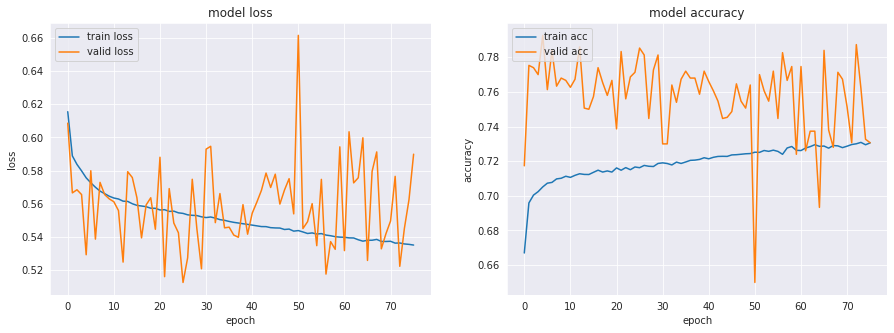

Training Network:  51.6369206905365
Evaluate Network:  533.5608065128326
Evaluate Network Complete:  585.7361104488373


In [66]:
identifier = 'Credit Card'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_credit_card, 
                                                                y_data_credit_card, 
                                                                nominal_features = nominal_features_credit_card, 
                                                                ordinal_features = ordinal_features_credit_card,
                                                                config = config,
                                                                distribution_list_evaluation = config['data']['distribution_list_eval'],
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Considered Columns:								 PAY_0   PAY_AMT2
Performance Network:								 0.783
Fidelity DT Sklearn Train Data:							 0.36033333333333334
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.635
Fidelity DT Sklearn Uniform Data:						 0.7473333333333333
Fidelity DT Sklearn Normal Data:						 0.6396666666666667
Fidelity DT I-Net:								 0.7503333333333333


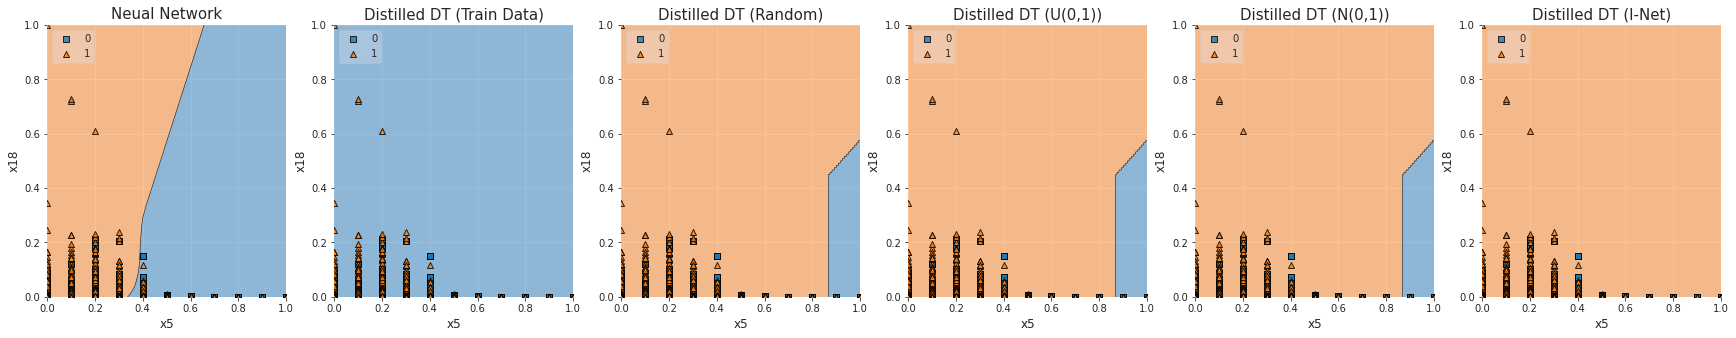

-----------------------------------------------------


In [67]:
if test_network_list[identifier] is not None:
    plot_decision_area_evaluation_all_distrib(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                None,
                                None,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAINDATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('STANDARDUNIFORM')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('STANDARDNORMAL')],
                                [dt_distilled_list_dict[identifier][0][dataset_size_list.index(config['evaluation']['random_evaluation_dataset_size_per_distribution'])]],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config['data']['distribution_list_eval'],
                                config
                               )

x0 = LIMIT_BAL (Scale: 1.01010101010101e-06)
x1 = SEX (Scale: 1.0)
x2 = EDUCATION (Scale: 0.16666666666666666)
x3 = MARRIAGE (Scale: 0.3333333333333333)
x4 = AGE (Scale: 0.017241379310344827)
x5 = PAY_0 (Scale: 0.1)
x6 = PAY_2 (Scale: 0.1)
x7 = PAY_3 (Scale: 0.1)
x8 = PAY_4 (Scale: 0.1)
x9 = PAY_5 (Scale: 0.1)
x10 = PAY_6 (Scale: 0.1)
x11 = BILL_AMT1 (Scale: 8.848844916028886e-07)
x12 = BILL_AMT2 (Scale: 9.490295224103831e-07)
x13 = BILL_AMT3 (Scale: 5.490423877194591e-07)
x14 = BILL_AMT4 (Scale: 9.41986800880946e-07)
x15 = BILL_AMT5 (Scale: 9.915667250038424e-07)
x16 = BILL_AMT6 (Scale: 7.684817950505162e-07)
x17 = PAY_AMT1 (Scale: 1.1447515431250802e-06)
x18 = PAY_AMT2 (Scale: 5.937329116246373e-07)
x19 = PAY_AMT3 (Scale: 1.1160216061782956e-06)
x20 = PAY_AMT4 (Scale: 1.610305958132045e-06)
x21 = PAY_AMT5 (Scale: 2.344506469665603e-06)
x22 = PAY_AMT6 (Scale: 1.8915534571922537e-06)


Accuracy Distilled Train 0.36033333333333334
Accuracy Distilled Train (Train Data) 0.4495137804202146

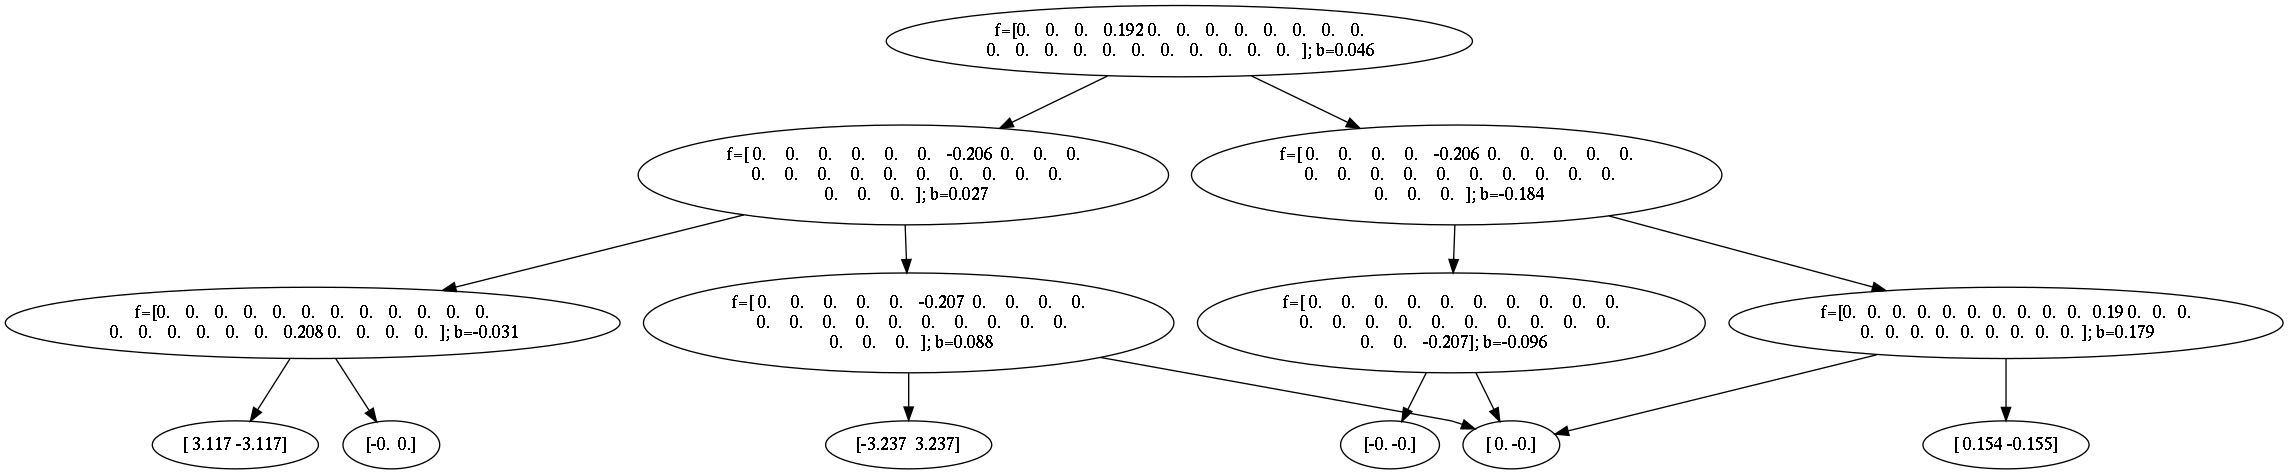

Accuracy I-Net 0.7503333333333333
F1-Score  I-Net 0.6462970077649669


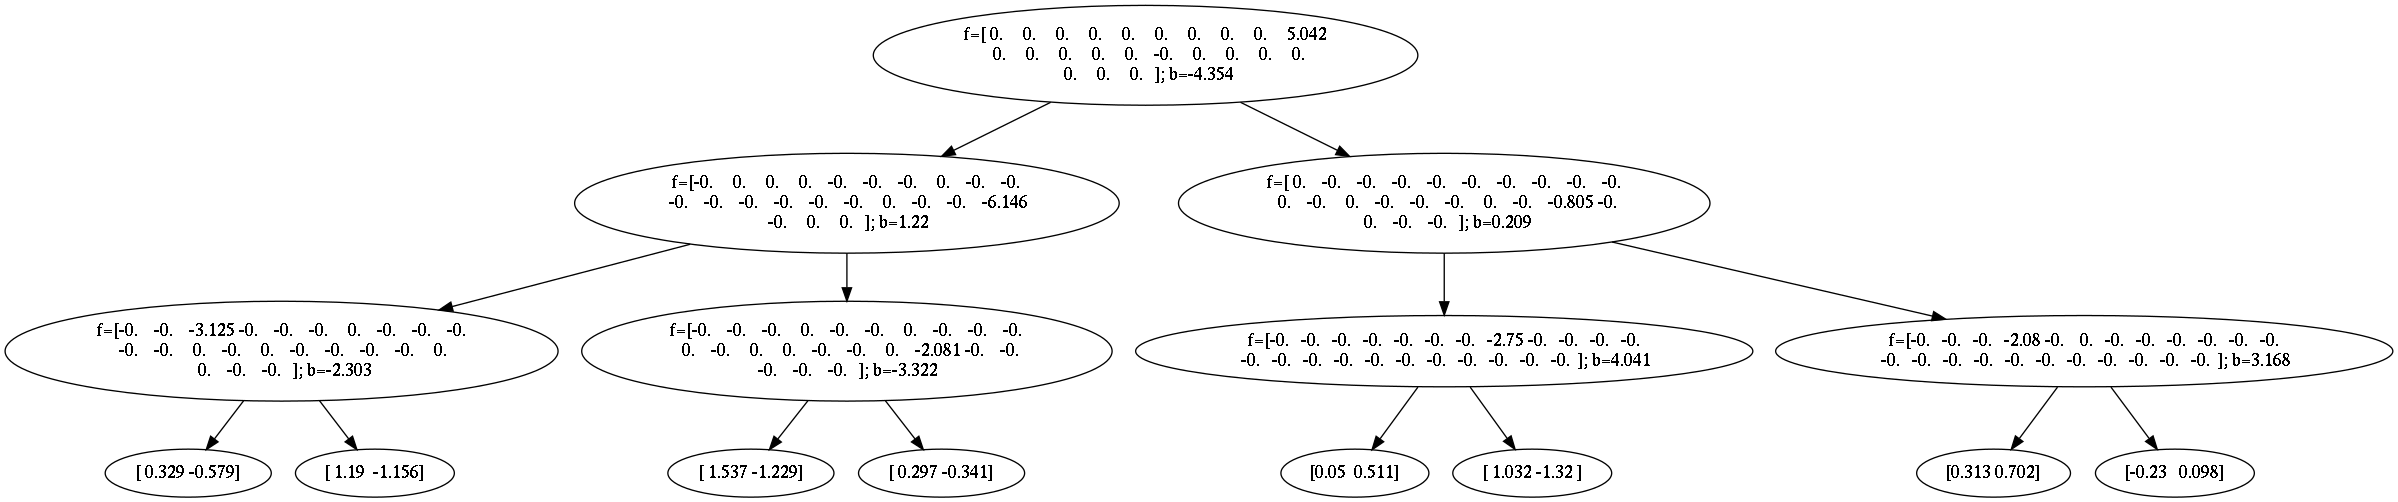

Accuracy Distilled Random 0.25266666666666665
Accuracy Distilled Random (Train Data) 0.6713
F1-Score  Distilled Random 0.10192726627638815
F1-Score  Distilled Random (Train Data) 0.5392732483695327


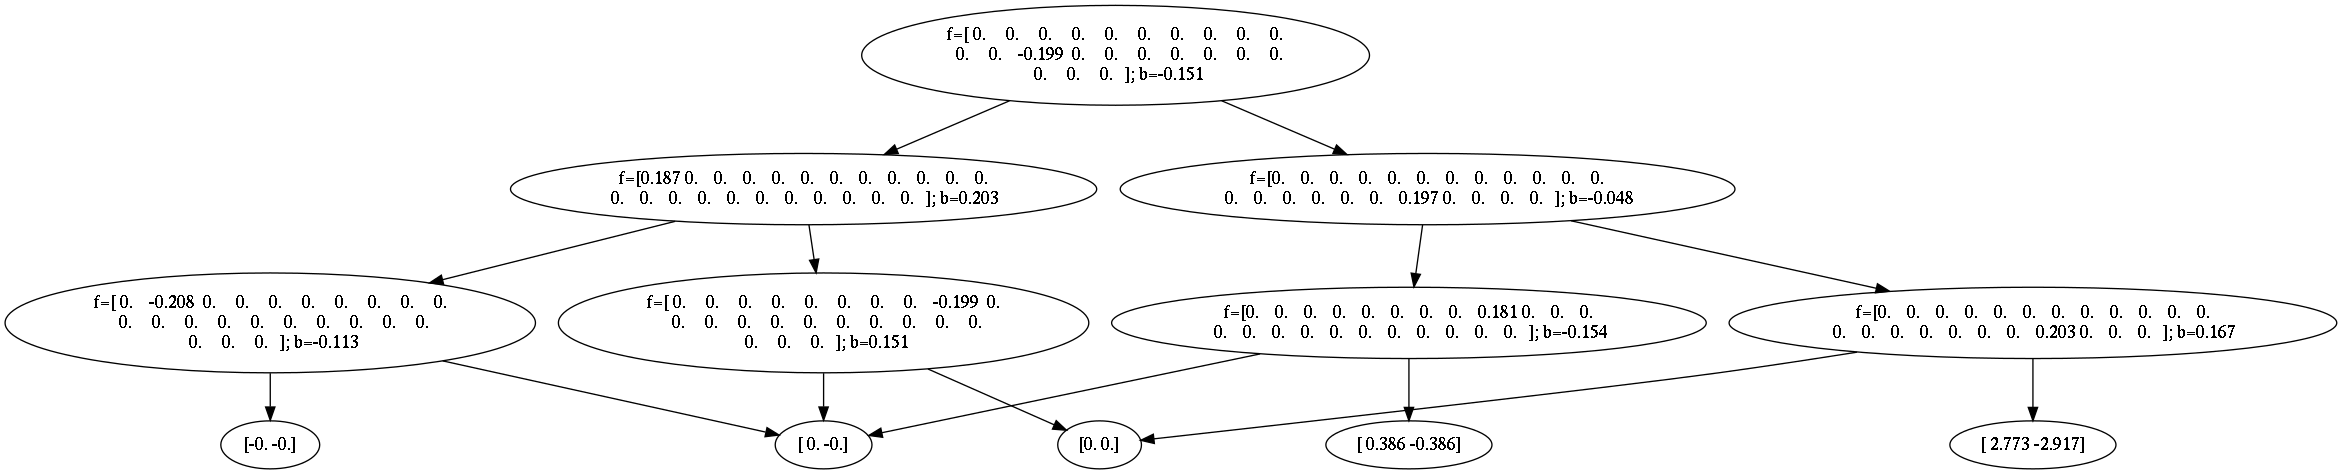

Accuracy Distilled Uniform 0.7473333333333333
Accuracy Distilled Uniform (Train Data) 0.8506
F1-Score  Distilled Uniform 0.6392679638814701
F1-Score  Distilled Uniform (Train Data) 0.7887900812724833


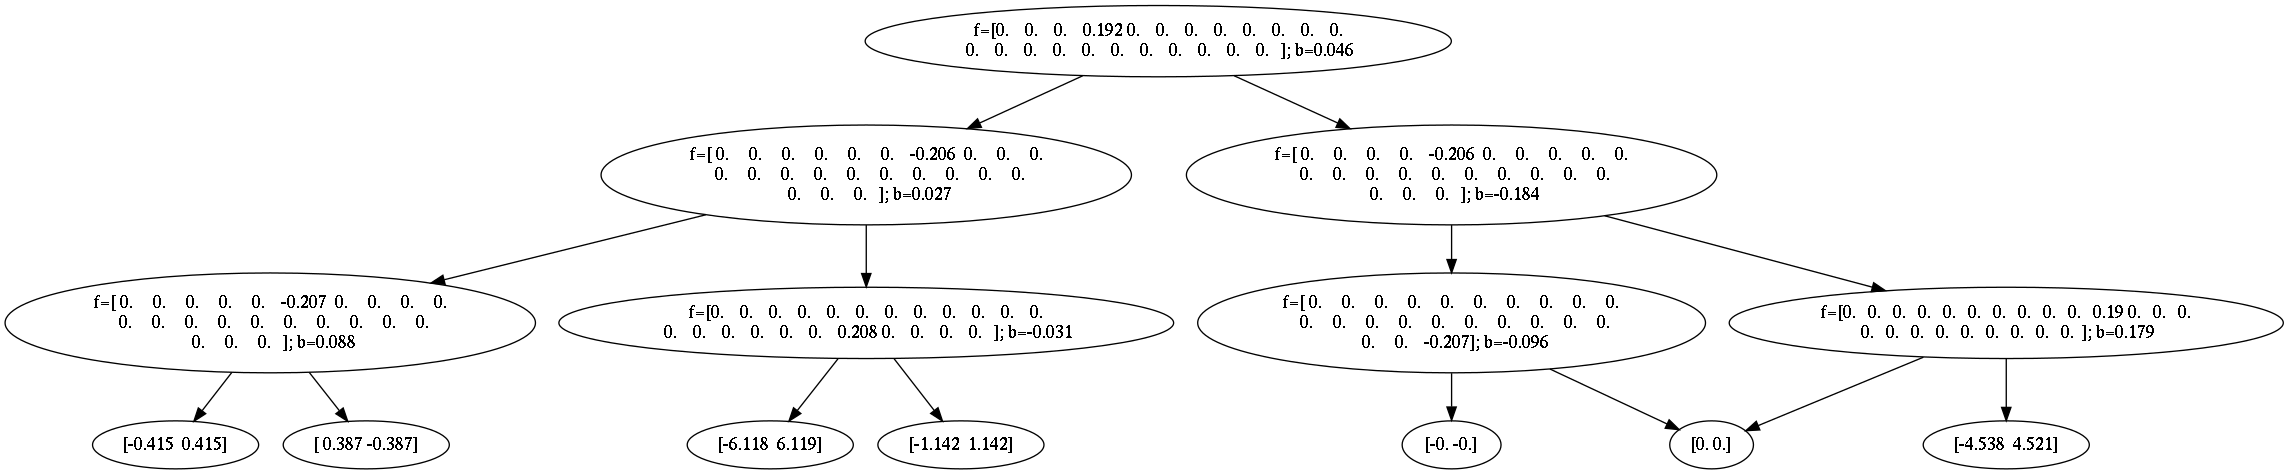

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

In [68]:
if test_network_list[identifier] is not None:
    for index, (var_name, feature_name) in enumerate(zip(['x'+str(i) for i in range(len(data_dict[identifier]['X_train'].columns))], list(data_dict[identifier]['X_train'].columns))):
        scale_feature = normalizer_list_dict[identifier][index].scale_[0]
        print(var_name, '=', feature_name, '(Scale: ' +  str(scale_feature) + ')')
        
    acc_list = [results_dict[identifier][i]['dt_scores']['accuracy_' + str(distribution_list_eval[0])] for i in range(max(loc for loc, val in enumerate(dataset_size_list) if val == dataset_size_list[0]))]
    idx_min = np.argsort(acc_list)[0]#[len(acc_list)//2]
    idx_uniform = dataset_size_list.index('STANDARDUNIFORM')
    idx_train = dataset_size_list.index('TRAINDATA')
    
    print('\n')
    if config['function_family']['dt_type'] == 'vanilla':
        print('Accuracy Distilled Train', results_dict[identifier][idx_train]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train', results_dict[identifier][idx_train]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_train], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()
        
        print('Accuracy I-Net', results_dict[identifier][idx_min]['inet_scores']['accuracy'])
        print('F1-Score  I-Net', results_dict[identifier][idx_min]['inet_scores']['f1_score'])
        plt.figure(figsize=(15,8))
        dt_inet = parameterDT(dt_inet_dict[identifier], config, normalizer_list=normalizer_list_dict[identifier])
        image = dt_inet.plot()
        display(image)
        
        print('Accuracy Distilled Random', results_dict[identifier][idx_min]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random', results_dict[identifier][idx_min]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_min], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()
        
        print('Accuracy Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])
        plt.figure(figsize=(15,8))
        plot_tree(dt_distilled_list_dict[identifier][0][idx_uniform], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
        plt.show()      

 
    else:
        print('Accuracy Distilled Train', results_dict[identifier][idx_train]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train', results_dict[identifier][idx_train]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score Distilled Train (Train Data)', results_dict[identifier][idx_train]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_train].plot_tree()
        display(image)
        
        print('Accuracy I-Net', results_dict[identifier][idx_min]['inet_scores']['accuracy'])
        print('F1-Score  I-Net', results_dict[identifier][idx_min]['inet_scores']['f1_score'])
        plt.figure(figsize=(15,8))
        dt_parameters = dt_inet_dict[identifier]
        tree = generate_random_decision_tree(config)
        tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
        image = tree.plot_tree()
        display(image)

        print('Accuracy Distilled Random', results_dict[identifier][idx_min]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random', results_dict[identifier][idx_min]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Random (Train Data)', results_dict[identifier][idx_min]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])        
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_min].plot_tree()
        display(image)
        
        print('Accuracy Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_' + str(distribution_list_eval[0])])
        print('Accuracy Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['accuracy_data_random_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_' + str(distribution_list_eval[0])])
        print('F1-Score  Distilled Uniform (Train Data)', results_dict[identifier][idx_uniform]['dt_scores']['f1_score_data_random_' + str(distribution_list_eval[0])])
        plt.figure(figsize=(15,8))
        image = dt_distilled_list_dict[identifier][0][idx_uniform].plot_tree()
        display(image)     

# Plot and Save Results

In [69]:
identifier_list_reduced = deepcopy(identifier_list)
for identifier in identifier_list:
    if test_network_list[identifier] is None:
        identifier_list_reduced.remove(identifier)

try:
    #print_complete_performance_evaluation_results(results_dict, identifier_list, dataset_size_list, dataset_size=config['evaluation']['random_evaluation_dataset_size_per_distribution'])
    complete_performance_evaluation_results = get_complete_performance_evaluation_results_dataframe(results_dict, 
                                                                                                    identifier_list_reduced, 
                                                                                                    dataset_size_list,
                                                                                                    dataset_size=config['evaluation']['random_evaluation_dataset_size_per_distribution'])
    display(complete_performance_evaluation_results.head(20))
except:
    pass

try:
    #print_complete_performance_evaluation_results(results_dict, identifier_list, dataset_size_list, dataset_size=config['evaluation']['random_evaluation_dataset_size_per_distribution'])
    complete_performance_evaluation_results = get_complete_performance_evaluation_results_dataframe_all_distrib(results_dict, 
                                                                                                                identifier_list_reduced, 
                                                                                                                dataset_size_list,
                                                                                                                distribution_list_evaluation = config['data']['distribution_list_eval'],
                                                                                                                dataset_size=config['evaluation']['random_evaluation_dataset_size_per_distribution'])
    display(complete_performance_evaluation_results.head(20))
except:
    pass

#print_network_distances(distances_dict)
network_distances = get_print_network_distances_dataframe(distances_dict)
display(network_distances.head(20))

,Acc Distilled (Train Data),Acc Distilled,Acc Distilled STD,Acc I-Net,Soft BC Distilled (Train Data),Soft BC Distilled,Soft BC Distilled STD,Soft BC I-Net,BC Distilled (Train Data),BC Distilled,BC Distilled STD,BC I-Net,F1 Score Distilled (Train Data),F1 Score Distilled,F1 Score Distilled STD,F1 Score I-Net,ROC AUC Score Distilled (Train Data),ROC AUC Score Distilled,ROC AUC Score Distilled STD,ROC AUC Score I-Net,Runtime Distilled (Train Data),Runtime Distilled,Runtime Distilled STD,Runtime I-Net
Credit Card,0.360,0.652,0.000,0.750,0.690,0.690,0.000,0.681,0.679,0.689,0.000,0.638,0.316,0.565,0.000,0.646,0.697,0.419,0.000,0.725,43.331,20.427,NaN,0.103


,Acc Distilled (Train Data),Acc Distilled (Standard Uniform),Acc Distilled (Standard Normal),"Acc Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson'])","STD Acc Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson'])",Acc I-Net,Soft BC Distilled (Train Data),Soft BC Distilled (Standard Uniform),Soft BC Distilled (Standard Normal),"Soft BC Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson'])","STD Soft BC Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson'])",Soft BC I-Net,BC Distilled (Train Data),BC Distilled (Standard Uniform),BC Distilled (Standard Normal),"BC Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson'])","STD BC Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson'])",BC I-Net,F1 Score Distilled (Train Data),F1 Score Distilled (Standard Uniform),F1 Score Distilled (Standard Normal),"F1 Score Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson'])","STD F1 Score Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson'])",F1 Score I-Net,ROC AUC Score Distilled (Train Data),ROC AUC Score Distilled (Standard Uniform),ROC AUC Score Distilled (Standard Normal),"ROC AUC Score Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson'])","STD ROC AUC Score Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson'])",ROC AUC Score I-Net,Runtime Distilled (Train Data),Runtime Distilled (Standard Uniform),Runtime Distilled (Standard Normal),"Runtime Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson'])","STD Runtime Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson'])",Runtime I-Net
Credit Card,0.360,0.747,0.640,0.652,0.165,0.750,0.690,0.676,0.694,0.690,0.012,0.681,0.679,0.590,0.767,0.689,0.069,0.638,0.316,0.639,0.600,0.565,0.164,0.646,0.697,0.417,0.421,0.419,0.112,0.725,43.331,9.589,14.274,20.427,11.662,0.103


,Average Z-Score (Sample to Train Data),Average Distance to Initialization,Average Mean Distance to Train Data,Average Distance to closest Train Data Sample,Average Biggest Distance for Single Neuron,Minimum Biggest Distance for Single Neuron
train,1774.704,359.299,524.490,0.000,3.548,0.000
valid,1484.752,290.741,465.441,301.794,3.291,1.732
test,1607.146,313.723,482.482,307.515,3.365,1.694
Titanic,NaN,NaN,NaN,NaN,NaN,NaN
Loan House,NaN,NaN,NaN,NaN,NaN,NaN
Medical Insurance,NaN,NaN,NaN,NaN,NaN,NaN
Cervical Cancer,NaN,NaN,NaN,NaN,NaN,NaN
Brest Cancer Wisconsin,NaN,NaN,NaN,NaN,NaN,NaN
Wisconsin Diagnostic Breast Cancer,NaN,NaN,NaN,NaN,NaN,NaN
Heart Disease,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
writepath_complete = './results_complete.csv'
writepath_summary = './results_summary.csv'

#TODO: ADD COMPLEXITY FOR DTS

if different_eval_data:
    flat_config = flatten_dict(config_train)
else:
    flat_config = flatten_dict(config)    

flat_dict_train = flatten_dict(inet_evaluation_result_dict_train)
flat_dict_valid = flatten_dict(inet_evaluation_result_dict_valid)
if not evaluate_distribution:
    flat_dict_test = flatten_dict(inet_evaluation_result_dict_test)
else:
    flat_dict_test = flatten_dict(inet_evaluation_result_dict_complete_by_distribution_test)

header_column = ''  

for key in flat_config.keys():
    header_column += key
    header_column += ';'     

number_of_evaluated_networks = np.array(flat_dict_train['inet_scores_binary_crossentropy']).shape[0]
for key in flat_dict_train.keys():
    #if 'function_values' not in key:
    for i in range(number_of_evaluated_networks):
        header_column += key + '_train_' + str(i) + ';'  

number_of_evaluated_networks = np.array(flat_dict_valid['inet_scores_binary_crossentropy']).shape[0]
for key in flat_dict_valid.keys():
    #if 'function_values' not in key:
    for i in range(number_of_evaluated_networks):
        header_column += key + '_valid_' + str(i) + ';'       

number_of_evaluated_networks = np.array(flat_dict_test[list(flat_dict_test.keys())[0]]).shape[0]
for key in flat_dict_test.keys():
    #if 'function_values' not in key:
    for i in range(number_of_evaluated_networks):
        header_column += key + '_test_' + str(i) + ';'          

header_column += '\n'


if os.path.exists(writepath_complete):        
    with open(writepath_complete, 'r') as text_file: 
        lines = text_file.readlines()
    
    counter = 1
    while lines[0] != header_column:  
        writepath_complete = './results_complete-' + str(counter) + '.csv' 
        if os.path.exists(writepath_complete):
            with open(writepath_complete, 'r') as text_file: 
                lines = text_file.readlines()
        else:
            break
        counter += 1

if not os.path.exists(writepath_complete):
    with open(writepath_complete, 'w+') as text_file: 
        text_file.write(header_column)

    
with open(writepath_complete, 'a+') as text_file:  
    for value in flat_config.values():
        text_file.write(str(value))
        text_file.write(';')
            
        
    number_of_evaluated_networks = np.array(flat_dict_train['inet_scores_binary_crossentropy']).shape[0]
    for key, values in flat_dict_train.items():
        #if 'function_values' not in key:
        for score in values:
            text_file.write(str(score) + ';')   

    number_of_evaluated_networks = np.array(flat_dict_valid['inet_scores_binary_crossentropy']).shape[0]
    for key, values in flat_dict_valid.items():
        #if 'function_values' not in key:
        for score in values:
            text_file.write(str(score) + ';')   

    number_of_evaluated_networks = np.array(flat_dict_test[list(flat_dict_test.keys())[0]]).shape[0]
    for key, values in flat_dict_test.items():
        #if 'function_values' not in key:
        for score in values:
            text_file.write(str(score) + ';')   
                    
    text_file.write('\n')            

    text_file.close()  
    


In [71]:
inet_evaluation_result_dict_mean_train_flat = flatten_dict(inet_evaluation_result_dict_mean_train)
inet_evaluation_result_dict_mean_valid_flat = flatten_dict(inet_evaluation_result_dict_mean_valid)
if not evaluate_distribution:
    inet_evaluation_result_dict_mean_test_flat = flatten_dict(inet_evaluation_result_dict_mean_test)
else:
    inet_evaluation_result_dict_mean_test_flat = flatten_dict(inet_evaluation_result_dict_mean_by_distribution_test)

#identifier_list_synthetic = ['train', 'valid', 'test']
identifier_list_combined = list(flatten_list([identifier_list, ['train', 'valid', 'test']]))

header_column = ''

for key in flat_config.keys():
    header_column += key + ';'

for key in inet_evaluation_result_dict_mean_train_flat.keys():
    header_column += 'train_' + key + ';'
for key in inet_evaluation_result_dict_mean_valid_flat.keys():
    header_column += 'valid_' + key + ';'          
for key in inet_evaluation_result_dict_mean_test_flat.keys():
    header_column += 'test_' + key + ';'                

for dataset_size in dataset_size_list:
    for identifier in identifier_list:
        results_dict_flat = flatten_dict(results_dict[identifier][-2])
        #del results_dict_flat['function_values_y_test_inet_dt']
        #del results_dict_flat['function_values_y_test_distilled_dt']

        for key in results_dict_flat.keys():
            header_column += key + '_' + identifier + '_' + str(dataset_size) + ';'                                   

for key in distances_dict['train'].keys():
    for identifier in identifier_list_combined:
        header_column += key + '_' + identifier + ';' 

header_column += '\n'
 
if os.path.exists(writepath_summary):        
    with open(writepath_summary, 'r') as text_file: 
        lines = text_file.readlines()

    counter = 1
    while lines[0] != header_column:  
        writepath_summary = './results_summary-' + str(counter) + '.csv' 
        if os.path.exists(writepath_summary):
            with open(writepath_summary, 'r') as text_file: 
                lines = text_file.readlines()
        else:
            break
        counter += 1

if not os.path.exists(writepath_summary):
    with open(writepath_summary, 'w+') as text_file: 
        text_file.write(header_column)

with open(writepath_summary, 'a+') as text_file: 
    
    for value in flat_config.values():
        text_file.write(str(value) + ';')
        
    for value in inet_evaluation_result_dict_mean_train_flat.values():
        text_file.write(str(value) + ';')
    for value in inet_evaluation_result_dict_mean_valid_flat.values():
        text_file.write(str(value) + ';')            
    for value in inet_evaluation_result_dict_mean_test_flat.values():
        text_file.write(str(value) + ';')

    for i in range(len(dataset_size_list)):
        for identifier in identifier_list:
            evaluation_result_dict_flat = flatten_dict(evaluation_result_dict[identifier])
            #del evaluation_result_dict_flat['function_values_y_test_inet_dt']
            #del evaluation_result_dict_flat['function_values_y_test_distilled_dt']
            
            for key, values in evaluation_result_dict_flat.items():
                text_file.write(str(values[i]) + ';')    #values[i]        
     
    for key in distances_dict['train'].keys():
        for identifier in identifier_list_combined:
            text_file.write(str(distances_dict[identifier][key]) + ';')      
    
    text_file.write('\n')

    text_file.close()      

In [72]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()

  0%|          | 0/50 [00:00<?, ?it/s]
